In [1]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import wurst as w

import re
import time
import copy

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.patches as mpatches  # Import for the legend patches
import matplotlib.lines as mlines  # Import for circle patches in the legend
import matplotlib.patches as patches

from rapidfuzz import fuzz, process
import matplotlib.pyplot as plt

from config import * #some main key parameters needed.
from private_keys import * #import secret keys
from db_functions import * # this is a python file with self-created functions needed to run this notebook
from functions import *
from regionalization import *
from mapping import *
from plotting import *

import uuid
from prettytable import PrettyTable

import seaborn as sns
from collections import defaultdict
import pickle
import tqdm
from tqdm import tqdm

import premise
import bw2data as bd
from bw2data import Database, Method
import bw2io as bi 
premise.__version__

Adding REMIND and IMAGE topology using regionalization.py


(2, 2, 7)

### 1. Get and set bw project (here, the new databases and activities are already generated in ``0_set_up_database_gen_acts``:

In [2]:
# Import project
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT, bw.databases,PROJECT_NAME

('ecoinvent-3.10-cutoff',
 Databases dictionary with 19 object(s):
 	ecoinvent-3.10-biosphere
 	ecoinvent-3.10-cutoff
 	ecoinvent_310_reference
 	ecoinvent_image_SSP2-RCP26_2030_base
 	ecoinvent_image_SSP2-RCP26_2035_base
 	ecoinvent_image_SSP2-RCP26_2040_base
 	ecoinvent_image_SSP2-RCP26_2045_base
 	ecoinvent_image_SSP2-RCP26_2050_base
 	ecoinvent_remind_SSP2-PkBudg1150_2030_base
 	ecoinvent_remind_SSP2-PkBudg1150_2035_base
 	ecoinvent_remind_SSP2-PkBudg1150_2040_base
 	ecoinvent_remind_SSP2-PkBudg1150_2045_base
 	ecoinvent_remind_SSP2-PkBudg1150_2050_base
 	steel_db
 	steel_db_future
 	steel_db_future_ccs
 	steel_db_future_ccs_remind_SSP2-PkBudg1150
 	steel_db_future_remind_SSP2-PkBudg1150
 	steel_market_db,
 'lca_steel_sector_cbam')

### The following are variables used to calculate different steps in this script:

In [3]:
calc_lca_impacts_ind = False # to calculate CBAM effectiveness of all pathways

In [4]:
create_new_steel_db = False
# current scenario:
calc_lca_impacts=False
contri=False
create_new_market_db=False
calculate_alpha = False

In [5]:
create_new_steel_db_future=False
calc_lca_impacts_future=False
contri_future=False

In [6]:
create_new_steel_db_future_ccs=False
calc_lca_impacts_future_ccs=False
contri_future_ccs=False

### 2. Get the merged steel databases:

In [7]:
plants_mod_all = pd.read_excel('data\merged_steel_dbs.xlsx')
plants_mod_all['Continent'] = plants_mod_all['Country/Area'].apply(get_continent)
plants_mod_future = plants_mod_all.copy()
plants_mod_all

,Unnamed: 0,Internal ID,Project name,Project website,Technology category,Announcement transparency,Project scale,Year to be online,Technology to be used,Technology details,...,"EAF steel production (DRI, coal)",BF production,DRI production,Plant name (English)_x,Power source,Retired Date,Category steel product,Steel products,Main production process,Main production equipment
0,6,GST-007,Hamburg H2,https://web.archive.org/web/https://future.ham...,Phasing out BF,High,Demo,2026,H-DRI,First tested using grey hydrogen from waste gases,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,GST-010,Whyalla Transformation Program,https://web.archive.org/web/https://www.gfgall...,Phasing out BF,High,Full scale,2027,NG-DRI to H-DRI,DRI+EAF Fed by Natural Gas in transitioning to...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,GST-012,tkH2Steel,https://web.archive.org/web/https://www.thysse...,Phasing out BF,High,Full scale,2028,NG-DRI to H-DRI,MIDREX Flex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,GST-013,Paradigm project,https://web.archive.org/web/https://tenova.com...,Phasing out BF,Medium,Full scale,2021,NG-DRI to H-DRI,Gas mixture composed by 30% of coke oven gas f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,GST-015,Oxelösund mini-mill,https://web.archive.org/web/https://www.ssab.c...,Complementing conventional steelmaking,High,Full scale,2026,BF-BOF to EAF for green iron,EAF using HBI and scrap,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,0.0000,Evonith Value Steel Wardha Steel Plant,NaN,NaN,finished rolled,flat steel,electric,EAF
1042,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,0.2681,Scaw Metals Group Germiston plant,NaN,NaN,semi-finished; finished rolled,billets; wire rod,integrated (DRI),"DRI, EAF"
1043,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0584,0.1281,Mono Steel Gujarat plant,Waste heat recover captive power plants (12 MW...,NaN,crude; semi-finished; finished rolled,sponge iron; pig iron; billets; bars,integrated (BF and DRI),"BF, DRI, other"
1044,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,0.0000,Donalam Targoviste plant,75MW PV park,NaN,finished rolled,rebar; wire rod,electric,EAF


In [8]:
# Define all relevant statuses
valid_statuses = [
    'Operating', 'operating',
    'operating pre-retirement',
    'Finalized (research & testing)'
]

# Get "operating" plants IDs based on those statuses
operating_plants = plants_mod_all.loc[
    plants_mod_all['Capacity operating status'].isin(valid_statuses),
    'Plant ID'
].unique()

# Now filter plants_mod_all using the broader statuses
plants_mod_all = plants_mod_all[
    plants_mod_all['Capacity operating status'].isin(valid_statuses) |
    (
        (plants_mod_all['Capacity operating status'] == 'operating pre-retirement') &
        (~plants_mod_all['Plant ID'].isin(operating_plants))
    )
]

# Optional: review resulting statuses
plants_mod_all['Capacity operating status'].value_counts()

Capacity operating status
operating                         783
operating pre-retirement           47
Operating                           3
Finalized (research & testing)      3
Name: count, dtype: int64

In [9]:
plants_mod_all = plants_mod_all[~plants_mod_all['steel_or_iron_production'].str.contains('iron', case=False, na=False)]
plants_mod_all['Capacity operating status'].value_counts()

Capacity operating status
operating                   751
operating pre-retirement     47
Name: count, dtype: int64

___
### 3. Now, we will have to write an equation that properly accounts what are the emission scopes and whether included in current CBAM:

___
### Determine alpha, share of embodied emissions

In [10]:
if calculate_alpha:
    alpha, data = calculate_cbam_alpha(
        db_name=NAME_REF_DB,
        method=MY_METHODS[0],
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL,
        threshold=90,
        cbam_threshold=0.2
    )
    print("Alpha:", alpha)
    %store alpha

    alpha_fut, data = calculate_cbam_alpha(
        db_name='ecoinvent_image_SSP2-RCP26_2040_base',
        method=MY_METHODS[0],
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL,
        threshold=90,
        cbam_threshold=0.2
    )
    print("Alpha future:", alpha_fut)
    %store alpha_fut
else:
    %store -r alpha
    %store -r alpha_fut
alpha,alpha_fut

Skipping low CBAM share: 0.0 market for iron scrap, unsorted
Skipping low CBAM share: 0.0 tinplate scrap, sorted to generic market for iron scrap, sorted, pressed
Skipping low CBAM share: 0.010043974517206953 nickel anode production, for electrolysis of iron ore
Skipping low CBAM share: 0.1740113773595351 ferromanganese production, high-coal, 74.5% Mn
Skipping low CBAM share: 0.06490466986426506 vanadium pentoxide and unalloyed steel production
Skipping low CBAM share: 0.0 tinplate scrap, sorted to generic market for iron scrap, sorted, pressed
Skipping low CBAM share: 0.0 tinplate scrap, sorted to generic market for iron scrap, sorted, pressed
Alpha: 0.7892742832153582
Stored 'alpha' (float)
Skipping low CBAM share: 0.0 market for iron scrap, unsorted
Skipping low CBAM share: -0.881027170995524 syngas, RWGS, Production, for Fischer Tropsch process, hydrogen from electrolysis
Skipping low CBAM share: 0.14940638118738517 syngas, RWGS, Production, for Fischer Tropsch process, hydrogen fr

(0.7892742832153582, 0.8837891705614797)

In [11]:
all_ei_databases = [db_2 for db_2 in bw.databases if "ecoinvent_image" in str(db_2) or NAME_REF_DB in str(db_2)]
for year in range(2025, 2051):
    matched_database = match_year_to_database(year)
    print(f"Matched database for year {year}: {matched_database}")

Matched database for year 2025: ecoinvent_310_reference
Matched database for year 2026: ecoinvent_310_reference
Matched database for year 2027: ecoinvent_310_reference
Matched database for year 2028: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2029: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2030: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2031: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2032: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2033: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2034: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2035: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2036: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2037: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2038: ecoinvent_image_SSP2-RCP26_2040_base
Matched database for year 2039: ecoinvent_image_SSP2-RCP26_2040_base
Matc

___
### 6. Now, create LCI for each facility and regionalize and account for potential low-carbon energy sources mentioned.

In [12]:
if create_new_steel_db:
    ref_db_w = w.extract_brightway2_databases(NAME_REF_DB, add_properties=False, add_identifiers=False)
    ref_db_w_2030 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2030_base', add_properties=False, add_identifiers=False)
    ref_db_w_2035 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2035_base', add_properties=False, add_identifiers=False)
    ref_db_w_2040 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2040_base', add_properties=False, add_identifiers=False)
    ref_db_w_2045 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2045_base', add_properties=False, add_identifiers=False)
    ref_db_w_2050 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2050_base', add_properties=False, add_identifiers=False)
    bio_db_w = w.extract_brightway2_databases(BIOSPHERE_DB, add_properties=False, add_identifiers=False)

    database_sel = {NAME_REF_DB:ref_db_w,
                    BIOSPHERE_DB:bio_db_w,
                    'ecoinvent_image_SSP2-RCP26_2030_base':ref_db_w_2030,
                    'ecoinvent_image_SSP2-RCP26_2035_base':ref_db_w_2035,
                    'ecoinvent_image_SSP2-RCP26_2040_base':ref_db_w_2040,
                    'ecoinvent_image_SSP2-RCP26_2045_base':ref_db_w_2045,
                    'ecoinvent_image_SSP2-RCP26_2050_base':ref_db_w_2050
                   }

Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 26110/26110 [00:00<00:00, 29173.08it/s]


Adding exchange data to activities


100%|████████████████████████████████████████████████████████████████████████| 804790/804790 [02:02<00:00, 6545.99it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 26110/26110 [00:06<00:00, 3885.70it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35209/35209 [00:00<00:00, 62145.85it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1017498/1017498 [02:19<00:00, 7300.25it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35209/35209 [00:08<00:00, 4329.16it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35215/35215 [00:00<00:00, 62227.49it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1018032/1018032 [02:22<00:00, 7150.29it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35215/35215 [00:09<00:00, 3680.16it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35222/35222 [00:00<00:00, 64743.10it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1018453/1018453 [02:12<00:00, 7680.78it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35222/35222 [00:09<00:00, 3682.26it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35224/35224 [00:00<00:00, 54043.77it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1018686/1018686 [02:08<00:00, 7902.11it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35224/35224 [00:08<00:00, 3956.90it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35224/35224 [00:00<00:00, 54407.43it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1018706/1018706 [02:32<00:00, 6666.02it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35224/35224 [00:09<00:00, 3867.78it/s]


Getting activity data


100%|███████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<00:00, 55929.70it/s]


Adding exchange data to activities


0it [00:00, ?it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<?, ?it/s]


In [13]:
def process_exchanges(activity_to_adapt, row, matched_database, db_name, iso2, db_sel, new_code, 
                      dict_power_acts=dict_power_acts, dict_hydrogen_acts=dict_hydrogen_acts):
    """
    Transform and regionalize exchanges from a base activity.

    This function processes exchanges in a given activity by modifying their location, linking them to external 
    datasets, and adjusting inputs, amounts, and metadata as needed. It handles different types of exchanges 
    (production, technosphere, and biosphere) and applies logic for electricity, hydrogen, and iron-related 
    inputs based on plant characteristics and power source.

    Main operations include:
        - Rebuilding production exchanges with updated references.
        - Regionalizing electricity exchanges (market or onsite generation).
        - Replacing hydrogen inputs with region-specific sources.
        - Updating iron production exchanges and substituting hydrogen flows.
        - Annotating exchanges with CBAM-relevant scope metadata.

    Parameters:
        activity_to_adapt (dict): Activity containing the original exchanges to be adapted.
        row (pandas.Series): Row with plant-specific data (e.g. power classification, location).
        matched_database (str): Name of the external database to link inputs to.
        db_name (str): Name of the current project database (used for production exchanges).
        iso2 (str): ISO 3166-1 alpha-2 country code used for matching regional datasets.
        db_sel (object): Selector or database interface for querying external activities.
        new_code (str): New activity code used for linking production and output exchanges.
        dict_power_acts (dict): Mapping of power classification to generator activity name and product.
        dict_hydrogen_acts (dict): Mapping of power classification to hydrogen production activity name and product.

    Returns:
        list: A list of processed and merged exchange dictionaries.

    Raises:
        ValueError: If an unknown exchange type is encountered.
    """
    new_exchanges = []
    elect_type_searched = 0
    
    for exc in activity_to_adapt['exchanges']:     
        #exc['input'] = None  # Reset before assigning
        if 'production' == exc['type']:
            new_exchanges.append( 
                {'location': exc['location'],
                 'database': db_name,
                 'name': exc['name'],
                 'reference product': exc['product'],
                 'unit': exc['unit'],
                 'type': 'production',
                 'amount': exc['amount'],
                 'input': (db_name, new_code),
                 'output': (db_name, new_code)  })
            
        elif 'technosphere' == exc['type']:
            #1 Power change
            if 'for electricity' in exc['name'] and 'electricity' in exc['product'] and exc['unit'] == 'kilowatt hour' and row['power_classification']!='grid':
                if elect_type_searched == 0:
                    # this is to avoid searching again for the same new electricity exchange if there are multiple power inputs 
                    power_generator = dict_power_acts[row['power_classification']]
                    power_generator_acts = w.get_many(db_sel,
                                                      w.equals("name", power_generator[0]),
                                                      w.equals("reference product", power_generator[1]) )
                    
                    possible_locations = [act['location'] for act in power_generator_acts]
            
                    best_matched_loc = match_best_location(iso2, possible_locations)[0] if iso2 not in possible_locations else iso2
                    #print(db_sel,power_generator[0],power_generator[1],best_matched_loc)

                    # Needed to link to dataset from external datab)ase
                    act_elect = w.get_one(db_sel,
                                    w.equals("name", power_generator[0]),
                                    w.equals("reference product", power_generator[1]),
                                    w.equals("unit", 'kilowatt hour'),
                                    w.equals("location", best_matched_loc) ).copy()

                    elect_type_searched = 1

                exc=exc.copy()
                
                # Note: we will have to provide the input as we link to external database
                exc_new = {'location': act_elect['location'],
                                     'name': act_elect['name'],
                                     'reference product': act_elect['reference product'],
                                     'unit': act_elect['unit'],
                                     'type': 'technosphere',
                                     #'database': db_name,
                                     'amount':exc['amount'],#IMPORTANT: take the initital amount in the exchange
                                     'input': (matched_database, act_elect['code'])  
                          }
                new_exchanges.append(exc_new)
                
            #2 Power change
            elif 'market group for electricity, ' in exc['name'] and iso2 not in ["BR", "IN", "US", "CN", "CA", "UG"] and exc['unit']=='kilowatt hour' and row['power_classification']=='grid':
                # Further regionalize power exchanges
                exc = exc.copy()
                init_name = exc['name']
                voltage_level = exc['name'].split("market group for electricity, ")[-1]
                #print(exc['name'], exc['location'])
                exc['name'] = f"market for electricity, {voltage_level}"
                #print(exc['name'], exc['location'])
                # Needed to link to dataset from external database
                try:
                    act = w.get_one(db_sel,
                                    w.equals("name", exc['name']),
                                    w.equals("reference product", exc['product']),
                                    w.equals("unit", exc['unit']),
                                    w.equals("location", iso2) ).copy()
                    exc['location'] = iso2
                except:
                    # If an error, then we will have to search for best matching one
                    activities_to_adapt_init = w.get_many(
                                                db_sel,
                                                w.equals("name", exc['name']),
                                                w.equals("reference product", exc['product']),
                                            )
            
                    possible_locations = [act['location'] for act in activities_to_adapt_init]
                    best_matched_loc = match_best_location(iso2, possible_locations)[0] if iso2 not in possible_locations else iso2
                    
                    if best_matched_loc == 'GLO':
                        print(f"Global dataset used for combi: {exc['name'],exc['product'],iso2,best_matched_loc, possible_locations}")
                        exc['name'] = init_name
                
                    act = w.get_one(db_sel, w.equals("name", exc['name']),\
                                    w.equals("reference product", exc['product']),
                                    w.equals("unit", exc['unit']),
                                    w.equals("location", best_matched_loc) )

                    exc['location'] = best_matched_loc
                
                # Note: we will have to provide the input as we link to external database
                exc['input'] = (matched_database, act['code'])          
                new_exchanges.append(exc)

            # We should also modify/replace the hydrogen source for DRI steel/iron, if needed:
            elif ('hydrogen, gaseous' in exc['product']):
                if row['power_classification']!='grid':
                    hydrogen_source = dict_hydrogen_acts[row['power_classification']]
                else:
                    hydrogen_source = ('hydrogen production, gaseous, 30 bar, from PEM electrolysis, power from market for electricity, medium voltage', 
                                       'hydrogen, gaseous, 30 bar')

                hydrogen_generator_acts = w.get_many(db_sel,
                                                  w.equals("name", hydrogen_source[0]),
                                                  w.equals("reference product", hydrogen_source[1]) )
                
                possible_locations = [act['location'] for act in hydrogen_generator_acts]
        
                best_matched_loc = match_best_location(iso2, possible_locations)[0] if iso2 not in possible_locations else iso2
                #print(hydrogen_source[0],hydrogen_source[1],best_matched_loc)

                # Needed to link to dataset from external database
                act_h2 = w.get_one(db_sel,
                                w.equals("name", hydrogen_source[0]),
                                w.equals("reference product", hydrogen_source[1]),
                                w.equals("unit", 'kilogram'),
                                w.equals("location", best_matched_loc) )

                exc_new = {'location': act_h2['location'],
                                     'name': act_h2['name'],
                                     'reference product': act_h2['reference product'],
                                     'unit': act_h2['unit'],
                                     'type': 'technosphere',
                                     #'database': db_name,
                                     'amount':exc['amount'],#IMPORTANT: take the initital amount in the exchange
                                     'input': (matched_database, act_h2['code'])}
                new_exchanges.append(exc_new)

            # We should also modify/replace the hydrogen source (h2-dri) and regionalize iron production
            elif ('technosphere' == exc['type'] and "iron" in str(exc['product']) and "iron production" in str(exc['name']) and not any(word in exc['name'] for word in ['treatment', 'sludge', 'ash', 'residues', 'waste'])):
                exc = exc.copy()
                init_amount = exc['amount']
            
                act_iron_init = w.get_one(db_sel,
                                          w.equals("name", exc['name']),
                                          w.equals("reference product", exc['product']),
                                          w.equals("unit", exc['unit']),
                                          w.equals("location", exc['location']) ) 

                act_iron = act_iron_init.copy()
                act_iron['location'] = iso2
                act_iron = relink_technosphere_exchanges(act_iron, db_sel, contained=False) 

                for exc_2 in act_iron['exchanges']:
                    exc_2_copy = exc_2.copy()
                    if 'hydrogen, gaseous' in str(exc_2_copy['product']):
                        if row['power_classification']!='grid':
                            hydrogen_source = dict_hydrogen_acts[row['power_classification']]
                            #print(f"REPLACING HYDROGEN SOURCE TO: {hydrogen_source}")
                        else:
                            hydrogen_source = ('hydrogen production, gaseous, 30 bar, from PEM electrolysis, power from market for electricity, medium voltage', 
                                               'hydrogen, gaseous, 30 bar')
                        
                        hydrogen_generator_acts = w.get_many(db_sel, 
                                                          w.equals("name", hydrogen_source[0]),
                                                          w.equals("reference product", hydrogen_source[1]) )
                        
                        possible_locations = [act['location'] for act in hydrogen_generator_acts]
                
                        best_matched_loc = match_best_location(iso2, possible_locations)[0] if iso2 not in possible_locations else iso2
                        #print(hydrogen_source[0],hydrogen_source[1],best_matched_loc)

                        # Needed to link to dataset from external database
                        act_h2 = w.get_one(db_sel,
                                        w.equals("name", hydrogen_source[0]),
                                        w.equals("reference product", hydrogen_source[1]),
                                        w.equals("unit", 'kilogram'),
                                        w.equals("location", best_matched_loc) )

                        exc_new = {'location': act_h2['location'],
                                             'name': act_h2['name'],
                                             'reference product': act_h2['reference product'],
                                             'unit': act_h2['unit'],
                                             'type': 'technosphere',
                                             'amount':exc_2_copy['amount']* init_amount,#IMPORTANT: take the initital amount in the exchange
                                             'input': (matched_database, act_h2['code'])}
                        new_exchanges.append(exc_new)

                    else:
                        # Needed to link to dataset from external database
                        if 'technosphere' == exc_2_copy['type']:
                            #print(exc_2_copy['name'],  init_amount_2, init_amount)
                            act = w.get_one(db_sel,
                                                        w.equals("name", exc_2_copy['name']),
                                                        w.equals("reference product", exc_2_copy['product']),
                                                        w.equals("unit", exc_2_copy['unit']),
                                                        w.equals("location", exc_2_copy['location']) ).copy()
                            
                            exc_2_copy['input'] = (matched_database, act['code'])
                            # Note: we will have to provide the input as we link to external database
                            exc_2_copy['amount'] = exc_2_copy['amount'] * init_amount
                            new_exchanges.append(exc_2_copy)
                        if 'biosphere' == exc_2_copy['type']:
                            act = w.get_one(bio_db_w,
                                                        w.equals("name", exc_2_copy['name']),
                                                        w.equals("unit", exc_2_copy['unit']),
                                                        w.equals("categories", exc_2_copy['categories']) ).copy()
                            exc_2_copy['input'] = (BIOSPHERE_DB, act['code'])
                            # Note: we will have to provide the input as we link to external database
                            exc_2_copy['amount'] = exc_2_copy['amount'] * init_amount
                            new_exchanges.append(exc_2_copy)
          
            else:
                # Needed to link to dataset from external database
                act = w.get_one(db_sel,
                                w.equals("name", exc['name']),
                                w.equals("reference product", exc['product']),
                                w.equals("unit", exc['unit']),
                                w.equals("location", exc['location']) ).copy()
                
                # Note: we will have to provide the input as we link to external database
                exc['input'] = (matched_database, act['code'])             
                new_exchanges.append(exc)
                
        elif 'biosphere' == exc['type']:
            # Needed to link to dataset from external database
            bio_flow = w.get_one(bio_db_w,
                                 w.equals("name", exc['name']),
                                 w.equals("unit", exc['unit']),
                                 w.equals("categories", exc['categories']) ).copy()

            # Note: we will have to provide the input as we link to external database
            exc['input'] = (BIOSPHERE_DB, bio_flow['code'])
            new_exchanges.append(exc)

        else:
            raise ValueError(f"ERROR: not known exchange type {exc['type']}")
            
    return merge_duplicate_exchanges(new_exchanges)

In [14]:
new_steel_activities = []
db_name = "steel_db"
start_idx = 0

all_names = []

if create_new_steel_db:
    from regionalization import * 
    
    if db_name in list(bw.databases):
        del bw.databases[db_name]

    counter = 1
    for counter, (index, row) in enumerate(plants_mod_all.iterrows(), start=1):
        if index < start_idx:
            continue  # Skip until we reach the desired index
            
        if row['steel_or_iron_production'] == 'both' or row['steel_or_iron_production'] == 'steel':
            sum_end_uses = row.filter(regex='steel production')
        elif row['steel_or_iron_production'] == 'iron':
            sum_end_uses = row.filter(like=' production').filter(regex='^(?!.*(steel|Company)).*$')
        else:
            raise ValueError("ERROR")
            
        sum_end_uses = sum_end_uses.dropna()[sum_end_uses > 0]
        row.fillna(np.nan,inplace=True)
        
        print(f"{counter}/{len(plants_mod_all)}", end="\r", flush=True)
        counter += 1

        for k, end_use in enumerate(list(sum_end_uses.index)):
            plant_name = row['Plant name (English)_x']
        
            if pd.isna(plant_name):
                year_field = row['Year to be online']
            else:
                year_field = row['Start date']

            # Determine the year of the steel plant, if not is unknown and we use the ref db.
            if pd.notna(year_field) and (isinstance(year_field, (int, float)) or (isinstance(year_field, str) and year_field.isdigit())):
                year = int(year_field)
                matched_database = match_year_to_database(year)
                db_sel = database_sel[matched_database]
            else:
                year = "Unknown"
                db_sel = database_sel[NAME_REF_DB]

            # get the best matched activity
            if pd.isna(plant_name):
                # this is the case with the low-carbon steel db, we have to make some changes
                plant_name = f"{row['Project name']}_{row['Internal ID']}_{year}"
                search_tech = f"{row['steel_or_iron_production']}-{row['steel_decarb_classification']}"
                match_activity = dict_acts[row["steel_classification"]].get(search_tech)
            else:
                match_activity = dict_acts[row["steel_classification"]].get(end_use)

            iso2 = country_to_iso2(row['Country/Area'])

            # Make new activity name and dictionary data + regionalize exchanges of this activity, which are processed in the next step
            new_act, activity_to_adapt, new_code = create_regionalized_activity(
                                db_sel,
                                match_activity,
                                iso2,
                                row,
                                end_use,
                                db_name,
                                plant_name,
                                year
                            )
            
            if new_act['name'] in all_names:
                print(f"WARNING: Activity already exists, skipping plant name with ID: '{new_act['name']}', '{row['Plant ID']}'")
                continue
                
            all_names.append(new_act['name'])

            # process exchanges, potentially further regioanlize by changing power, heat, and/or hydrogen sources used.
            new_act['exchanges'] = process_exchanges(activity_to_adapt, row, matched_database, db_name, iso2, db_sel, new_code)

            # add exchanges to transport the steel
            transport_ex = add_transport_exchanges(row['Continent'], db_sel, matched_database, km_transport_train=500)     
            new_act['exchanges'].extend(transport_ex)
            
            new_steel_activities.append(new_act)      

Vacuuming database 


#%store new_steel_activities
%store -r new_steel_activities

In [15]:
if create_new_steel_db:
    process_import(db_name, new_steel_activities, iam='image')

    annotate_exchanges_with_cbam(
        db_name=db_name,
        define_scope_cbam_func=define_scope_cbam,
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL)

Applying strategy: add_database_name
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 3.50 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
870 datasets
69803 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\lca_steel_sector_cbam.27d78f50af11f772309a5a15dc8c3210\output\db-matching-steel_db-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Title: Writing activities to SQLite3 database:
  Started: 09/10/2025 11:58:13
  Finished: 09/10/2025 11:58:24
  Total time elapsed: 00:00:11
  CPU %: 70.00
  Memory %: 25.40
Created database: steel_db


annotate_exchanges_with_cbam(
    db_name=db_name,
    define_scope_cbam_func=define_scope_cbam,
    cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL
)

___
### 7. Calculate LCA results:

In [16]:
file_path = "results/results_df.pkl"

columns = ['name', 'year', 'unit', 'country', 'reference product','production volume',"database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df = pd.DataFrame(columns=columns) #initialize df to store data in

start_idx=0
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts:
    acts = list(bw.Database(db_name))
    for i, act_sel in enumerate(tqdm(acts)):
        if i < start_idx:
            continue  # Skip until we reach the desired index
        
        db_name_exch = ""

        lca_scores = {}
        lca_scores_contri = {}

        for method in MY_METHODS:
            # Initialize LCA for the first method or reuse for subsequent methods
            if i == 0:
                lca = bw.LCA({act_sel: 1}, method=method)
                lca.lci()
                lca.lcia()
            else:
                if len(MY_METHODS)>1:
                    lca.switch_method(method)
                lca.redo_lcia({act_sel: 1})
            
            # Store the score for the current method
            lca_scores[f'lca_impact_{method[1]}'] = lca.score

            if 'climate change' in str(method) and contri:
                result_array = []
                for exc in act_sel.exchanges():
                    #print(exc['name'])
                    if exc['type'] == 'technosphere':
                        lca.redo_lcia({exc.input: exc['amount']})
                        result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'], exc['amount']))
                    elif exc['type'] == 'biosphere':
                        # Multiply amount by its CF
                        cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                        result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
    
                lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array

        result = {
            'name': act_sel['name'],
            'reference product': act_sel['reference product'],
            'country':act_sel['location'],
            'location': act_sel['location'],
            'production volume': act_sel['production volume'],
            'unit': act_sel['unit'],
            "database": act_sel['database'],
            "initial name": act_sel['name'].split(" for facility in")[0],
            'comment': act_sel['comment'],
            'year': int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act_sel['name'])) else None,
            'latitude': act_sel['comment'].split("latitude:")[1].split(",")[0],
            'longitude': act_sel['comment'].split("longitude:")[1].split(",")[0],
            'power_source': act_sel['comment'].split("power source:")[1].split(",")[0],
        }
    
        # update the result dictionary with lca scores
        result.update(lca_scores)
        result.update(lca_scores_contri)

        # Convert the result to a DataFrame
        result_df = pd.DataFrame([result])
    
        # Concatenate the result DataFrame with the main DataFrame
        results_df = pd.concat([results_df, result_df], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df = pickle.load(file)
results_df = results_df[results_df.year < 2026]  # for the current scenario, exclude facilities planned for the future
results_df["Plant_GHG_emissions_Mt"] = results_df['production volume']*results_df['lca_impact_climate change']

# Now, we also apply a function that excludes the transport exchanges we added, as not all steel will be imported to the EU
results_df["lca_impact_climate change_wo_transport"] = results_df['lca_impact_contri_climate change'].apply(sum_exchanges_wo_transport)
results_df["Plant_GHG_emissions_Mt_wo_transport"] = results_df['production volume']*results_df['lca_impact_climate change_wo_transport']
results_df

  0%|                                                                                          | 0/870 [00:00<?, ?it/s]C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_32008\3588394893.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_df], ignore_index=True)
100%|████████████████████████████████████████████████████████████████████████████████| 870/870 [34:55<00:00,  2.41s/it]


,name,year,unit,country,reference product,production volume,database,lca_impact_climate change,lca_impact_contri_climate change,location,initial name,comment,latitude,longitude,power_source,Plant_GHG_emissions_Mt,lca_impact_climate change_wo_transport,Plant_GHG_emissions_Mt_wo_transport
0,"steel production, converter, unalloyed, only p...",2019,kilogram,CN,"steel, unalloyed",2.160,steel_db,2.478229,"[(Carbon dioxide, fossil, 0.0627088510499116, ...",CN,"steel production, converter, unalloyed, only p...",Geography: Data are taken from basic oxygen f...,35.15735,119.133999,grid,5.352975,2.349599,5.075134
1,"steel production, converter, unalloyed, only p...",2024,kilogram,CN,"steel, unalloyed",4.480,steel_db,2.478229,"[(Carbon dioxide, fossil, 0.0627088510499116, ...",CN,"steel production, converter, unalloyed, only p...",Geography: Data are taken from basic oxygen f...,42.3249,125.246892,grid,11.102466,2.349599,10.526204
2,"steel production, converter, unalloyed, only p...",1986,kilogram,CN,"steel, unalloyed",1.600,steel_db,2.478229,"[(Carbon dioxide, fossil, 0.0627088510499116, ...",CN,"steel production, converter, unalloyed, only p...",Geography: Data are taken from basic oxygen f...,31.681005,120.251785,grid,3.965166,2.349599,3.759359
3,"steel production, converter, low-alloyed, only...",1971,kilogram,IN,"steel, low-alloyed",2.909,steel_db,2.192619,"[(Carbon dioxide, fossil, 0.3162672, 1, True, ...",IN,"steel production, converter, low-alloyed, only...",This process produces primary steel via Basic ...,17.612846,83.191918,natural gas,6.378327,2.063989,6.004144
4,"steel production, converter, unalloyed, only p...",2024,kilogram,CN,"steel, unalloyed",4.902,steel_db,2.478229,"[(Carbon dioxide, fossil, 0.0627088510499116, ...",CN,"steel production, converter, unalloyed, only p...",Geography: Data are taken from basic oxygen f...,39.468366,118.256774,grid,12.148278,2.349599,11.517735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,"steel production, electric, low-alloyed for fa...",2003,kilogram,CN,"steel, low-alloyed",0.490,steel_db,1.709169,"[(Antimony ion, 0.0, 1, True, 4.20301356762374...",CN,"steel production, electric, low-alloyed",This activity represents the production of sec...,29.836163,106.988138,grid,0.837493,1.580539,0.774464
866,"steel production, electric, low-alloyed for fa...",1813,kilogram,IT,"steel, low-alloyed",0.770,steel_db,0.589551,"[(Benzene, 0.0, 1, True, 3.63318042491699e-07)...",IT,"steel production, electric, low-alloyed",Geography: Data are taken from electric arc f...,46.008483,13.255117,grid,0.453955,0.563348,0.433778
867,"steel production, electric, low-alloyed for fa...",1961,kilogram,CA,"steel, low-alloyed",0.828,steel_db,1.001764,"[(Argon, 0.0, 1, True, 0.00329043), (Benzene, ...",CA,"steel production, electric, low-alloyed",This dataset represents the manufacturing of l...,50.51499,-104.630589,grid,0.829460,0.924347,0.765360
868,"steel production, electric, low-alloyed for fa...",2012,kilogram,SY,"steel, low-alloyed",0.980,steel_db,1.640481,"[(Antimony ion, 0.0, 1, True, 4.20301356762374...",SY,"steel production, electric, low-alloyed",This activity represents the production of sec...,33.626258,36.574968,grid,1.607671,1.511851,1.481614


In [17]:
total_emissions = results_df['Plant_GHG_emissions_Mt_wo_transport'].sum()
total_production = results_df['production volume'].sum()
emissions_intensity = total_emissions / total_production

print(f"Total GHG emissions (without transport): {total_emissions:.2f} Mt")
print(f"Total production volume: {total_production:.2f}")
print(f"Emissions intensity: {emissions_intensity:.2f} kgCO2-eq./kg steel")

Total GHG emissions (without transport): 4017.43 Mt
Total production volume: 1918.93
Emissions intensity: 2.09 kgCO2-eq./kg steel


In [18]:
# Determine scope of emissions as well as cbam:
results_df[['Scope 1', 'Scope 2', 'Scope 3']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_scope_contributions).apply(pd.Series)

results_df[['cbam_true', 'cbam_false']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha).apply(pd.Series)

results_df['cbam_true_total_cc'] = results_df['cbam_true'] * results_df['production volume']
results_df['cbam_false_total_cc'] = results_df['cbam_false'] * results_df['production volume']
results_df['share_cbam_covered'] = results_df['cbam_true_total_cc']/(results_df['cbam_true_total_cc'] + results_df['cbam_false_total_cc'])

results_df['latitude'] = pd.to_numeric(results_df['latitude'], errors='coerce')
results_df['longitude'] = pd.to_numeric(results_df['longitude'], errors='coerce')
results_df['share_cbam_covered'].describe()

count    843.000000
mean       0.628044
std        0.092625
min        0.284084
25%        0.601358
50%        0.649364
75%        0.700637
max        0.746655
Name: share_cbam_covered, dtype: float64

In [19]:
results_df[['cbam_true_efactor', 'cbam_false_efactor']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions_emission_factor, alpha=alpha).apply(pd.Series)

results_df['cbam_true_total_cc_efactor'] = results_df['cbam_true_efactor'] * results_df['production volume']
results_df['cbam_false_total_cc_efactor'] = results_df['cbam_false_efactor'] * results_df['production volume']
results_df['share_cbam_covered_efactor'] = results_df['cbam_true_total_cc_efactor']/(results_df['cbam_true_total_cc_efactor'] + results_df['cbam_false_total_cc_efactor'])
results_df['share_cbam_covered_efactor'].describe()

count    843.000000
mean       0.609839
std        0.111954
min        0.176899
25%        0.597805
50%        0.646244
75%        0.696269
max        0.742674
Name: share_cbam_covered_efactor, dtype: float64

## Some checks regarding act relevant precursors and if they are not matched:

In [20]:
cbam_issues_df = check_cbam_coverage(results_df, CBAM_RELEVANT_PRECURSORS_EXCL)
cbam_issues_df

""


In [21]:
df_countries = pd.read_excel(r'data\df_countries.xlsx', index_col = "location").reset_index()
#results_df = pd.merge(results_df, df_countries, on='location') # add lat lon info
# Add a new column to the DataFrame to classify countries as European or Non-European
results_df['region'] = results_df['location'].apply(lambda x: 'European' if x in european_countries else 'Non-European')
results_df["Plant_GHG_emissions_Mt"] = results_df['production volume']*results_df['lca_impact_climate change']

___
### 7. Get the steel from other continents and create national and continental steel markets:

In [22]:
#slide 36 of https://www.eurofer.eu/assets/publications/brochures-booklets-and-factsheets/european-steel-in-figures-2025/European-Steel-in-Figures-2025_23062025.pdf
steel_import_2024 = {
    "KR": 3304,  # South Korea
    "IN": 3296,  # India
    "TW": 2266,  # Taiwan
    "TR": 3909,  # Turkey
    "CN": 2206,  # China
    "VN": 2617,  # Vietnam
    "JP": 1403,  # Japan
    "EG": 1212,  # Egypt
    "UA": 1677,  # Ukraine
    "ID": 726,   # Indonesia
    "Others": 4988  # No ISO2 code for "Others"
}

exclude_countries = list(steel_import_2024.keys()) + eu27_countries
results_df['commodity_type'] = results_df['initial name'].map(dict_types)
exclude_countries.remove('Others')

In [23]:
results_df['commodity_type'].unique()

array(['primary steel (BF-BOF)', 'secondary steel (EAF)',
       'primary steel (DRI-EAF, NG)', 'primary steel (DRI-EAF, coal)'],
      dtype=object)

# Now, generate global and country-specific market activities for steel production:

In [24]:
if create_new_market_db:
    db_sel_markets = w.extract_brightway2_databases(db_name, add_properties=False, add_identifiers=False)
    #db_sel = w.extract_brightway2_databases(db_name, add_properties=False, add_identifiers=False)

Getting activity data


100%|█████████████████████████████████████████████████████████████████████████████| 870/870 [00:00<00:00, 25365.95it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████████| 69803/69803 [00:19<00:00, 3525.20it/s]


Filling out exchange data


100%|███████████████████████████████████████████████████████████████████████████████| 870/870 [00:01<00:00, 461.61it/s]


In [25]:
# Fill missing years with default (2024 assumed to be the "current" year)
results_df['year'] = results_df['year'].fillna(2025)

new_market_activities = []
db_name_markets = "steel_market_db"
name_comm = 'steel' # can be via primary or secondary production, or just a market combining them. 

# We don't make a distinction here between low-alloyed and unalloyed steel
if create_new_market_db:
    # create country-specific markets
    new_market_activities = create_steel_market_activities(results_df, db_sel_markets, db_name, db_name_markets )

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_32008\4028244827.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['year'] = results_df['year'].fillna(2025)


In [26]:
if create_new_market_db:
    market_definitions = [
        {
            "market_name": "Others",
            "market_location_label": "Others",
            "location_filter_fn": lambda df: ~df.location.isin(exclude_countries),
        },
        {
            "market_name": "Non-EU-27",
            "market_location_label": "Non-EU-27",
            "location_filter_fn": lambda df: ~df.location.isin(eu27_countries),
        },
        {
            "market_name": "EU-27",
            "market_location_label": "EU-27",
            "location_filter_fn": lambda df: df.location.isin(eu27_countries),
        },
        {
            "market_name": "GLO",
            "market_location_label": "GLO",
            "location_filter_fn": lambda df: df.location.notnull(),
        },
    ]

    # Now, make those larger markers and append to the country markers of before
    for market in market_definitions:
        new_market = create_market_activity(
            name_comm=name_comm,
            results_df=results_df,
            db_sel=db_sel_markets,
            db_name=db_name,
            db_name_markets=db_name_markets,
            market_name=market["market_name"],
            market_location_label=market["market_location_label"],
            location_filter_fn=market["location_filter_fn"],
            w=w
        )
        new_market_activities.append(new_market)
#new_market_activities[76]

In [27]:
if create_new_market_db:
    if db_name_markets in list(bw.databases):
        del bw.databases[db_name_markets]    
    create_database(db_name_markets)
    process_import(db_name_markets, new_market_activities)

Database 'steel_market_db' has been created and registered.
Applying strategy: add_database_name
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.09 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
77 datasets
2867 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\lca_steel_sector_cbam.27d78f50af11f772309a5a15dc8c3210\output\db-matching-steel_market_db-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/10/2025 13:09:41
  Finished: 09/10/2025 13:09:41
  Total time elapsed: 00:00:00
  CPU %: 38.30
  Memory %: 26.31
Created database: steel_market_db


sum_vol=0

for act in bw.Database('steel_db'):
    year = int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act['name'])) else None
    if year is None or year < 2024:
        print(year)
        sum_vol += float(act['production volume'])
sum_vol

# Make a global market with excluding countries given in the dictionary:

In [28]:
for act in bd.Database("steel_market_db"):
    if act['location'] == "Non-EU-27":
        print(act.as_dict())

{'location': 'Non-EU-27', 'database': 'steel_market_db', 'code': '311c926c9c844cb383cd5e8e2233584b', 'name': 'market for steel', 'reference product': 'steel', 'amount': 1, 'unit': 'kilogram', 'production volume': 1786.3990000000003}


In [29]:
for act in bd.Database("steel_market_db"):
    if act['location'] == "EU-27":
        print(act.as_dict())

{'location': 'EU-27', 'database': 'steel_market_db', 'code': '42dcc765d7904763b690f73c47ab1e4e', 'name': 'market for steel', 'reference product': 'steel', 'amount': 1, 'unit': 'kilogram', 'production volume': 132.533}


In [30]:
for act in bd.Database("steel_market_db"):
    if act['location'] == "GLO":
        print(act.as_dict())

{'location': 'GLO', 'database': 'steel_market_db', 'code': 'd3a34c8fa03146d6880a939b17a9c8ab', 'name': 'market for steel', 'reference product': 'steel', 'amount': 1, 'unit': 'kilogram', 'production volume': 1918.9319999999996}


In [31]:
import_df = pd.DataFrame({})

for import_c in list(steel_import_2024.keys()):
    act_market = [act for act in bd.Database("steel_market_db") if act['location'] == import_c][0]
    #print(act_market['name'], act_market['location'])

    # here we loop over the different steel plants in the market with their production shares
    # as such, we determine their (shifting) emissions/burdens and cbam effectiveness
    for exc in act_market.exchanges():
        if exc['type'] != 'production':
            #pass
            row_sel = results_df[results_df['name']==exc['name']].copy()
            # this is the amount of steel imported to the EU
            row_sel['production_volume_to_EU'] = exc['amount']*steel_import_2024[import_c]/1e3 #Megatonne steel

            row_sel['Mt_emissions_shift_from_EU'] = row_sel['production_volume_to_EU'] * row_sel['lca_impact_climate change']
            row_sel['cbam_included_emissions_export_EU'] = row_sel['production_volume_to_EU'] * row_sel['lca_impact_climate change'] * row_sel['share_cbam_covered']
            row_sel['cbam_excluded_emissions_export_EU'] = row_sel['production_volume_to_EU'] * row_sel['lca_impact_climate change'] * (1-row_sel['share_cbam_covered'])
            
            import_df = pd.concat([import_df, row_sel], ignore_index=True)
            #print(exc['name'], megatonne_steel_prod_plant)

# Calculate totals
excluded_emissions = import_df['cbam_excluded_emissions_export_EU'].sum()
included_emissions = import_df['cbam_included_emissions_export_EU'].sum()
total_emissions = excluded_emissions + included_emissions
production_volume = import_df['production_volume_to_EU'].sum()

# Share of emissions covered under CBAM
if total_emissions > 0:
    cbam_coverage_share = included_emissions / total_emissions
else:
    cbam_coverage_share = 0  # Avoid division by zero

# Print report
print(f"CBAM emissions (EU import):")
print(f"  - Total production volume exported to EU: {production_volume:,.2f} Mt")
print(f"  - Emissions excluded from CBAM: {excluded_emissions:,.2f} tonnes CO2e")
print(f"  - Emissions included in CBAM (covered): {included_emissions:,.2f} tonnes CO2e")
print(f"  - Share of emissions covered under CBAM: {cbam_coverage_share:.2%}")

CBAM emissions (EU import):
  - Total production volume exported to EU: 27.60 Mt
  - Emissions excluded from CBAM: 18.76 tonnes CO2e
  - Emissions included in CBAM (covered): 39.16 tonnes CO2e
  - Share of emissions covered under CBAM: 67.61%


___
### 8. We have all the results now for plotting
### Plot steel production

#https://static1.squarespace.com/static/5877e86f9de4bb8bce72105c/t/624ebc5e1f5e2f3078c53a07/1649327229553/Steel+climate+impact-benchmarking+report+7April2022.pdf
#https://climateactiontracker.org/documents/1222/CAT_2024-07-09_Briefing_ParisBenchmarks_SteelSector.pdf

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


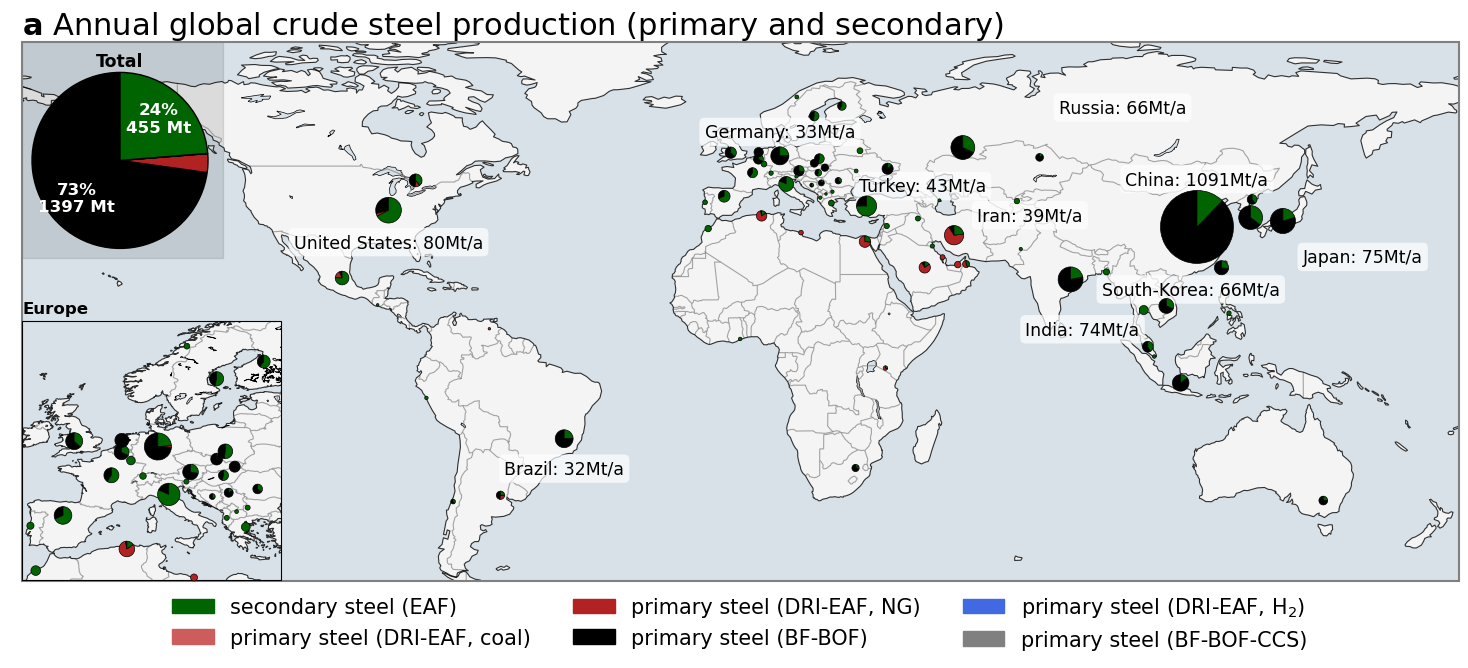

In [32]:
# List of titles and potential columns
titles = [r'$\mathbf{a}$ Annual global crude steel production (primary and secondary)']
pot_cols = ['production volume']

plot_steel_map(results_df, pot_cols, subplot=False, titles = titles, division_bubble=18, amount_show_bubble=30, export_figure='annual_global_steel_production',
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +23),
                           'Ukraine': (+4, +22),
                        'China': (+12, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (5, -19),
                           'Taiwan': (-12, -19),
                        'Japan': (-9, -20),
                        'South-Korea': (-18, +15),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (+5, -14),
                        'United States': (-8, 0),
                        'Taiwan': (-17, -8),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (80, -7.5))

## Plot steel supply curve for current year

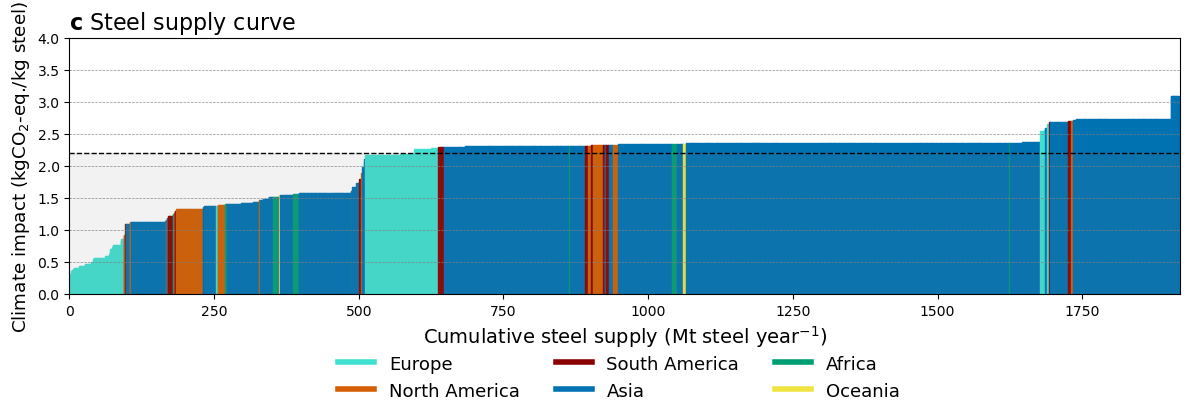

In [33]:
plot_steel_supply_curve(
    results_df=results_df,
    get_continent_func=get_continent,
    color_mapping=dict_color_fig_2_c,
    emission_thresholds={'BF-BOF (2025)': 2.2},
    output_path="figs/steel_supply_curve.png",
    cut_axis_lim = 4,
    zoom=False,
)

In [34]:
summed_results_df = results_df.groupby(['country']).sum()
summed_results_df['share_cbam_covered_weighted'] = summed_results_df['cbam_true_total_cc'] / ( summed_results_df['cbam_true_total_cc'] + summed_results_df['cbam_false_total_cc'] )
summed_results_df['share_cbam_covered_weighted'].sort_values()

country
NO    0.284084
AL    0.326198
BY    0.340731
CH    0.351483
LU    0.406821
        ...   
BA    0.728182
UA    0.734521
CZ    0.739878
SK    0.741206
NL    0.741291
Name: share_cbam_covered_weighted, Length: 73, dtype: float64

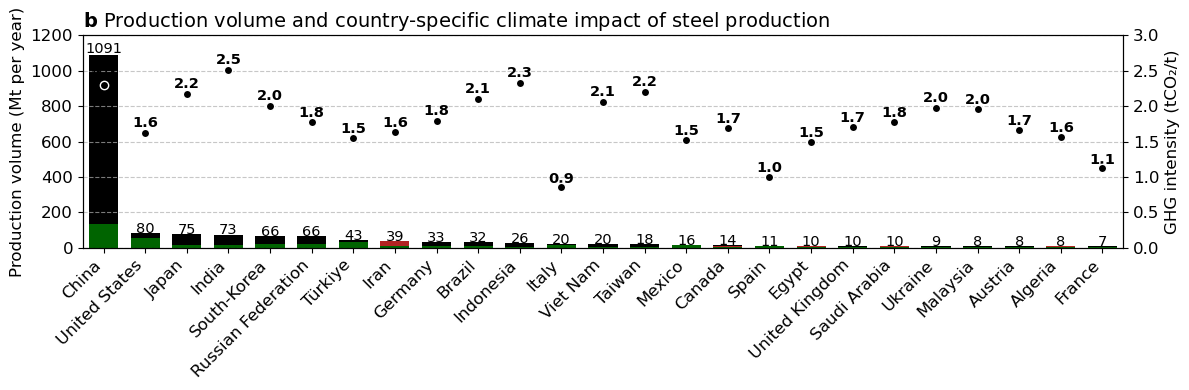

In [35]:
for col in ['production volume']:
    plot_steel_production(results_df, production_col=col, export_figure='prod_fig_intensity')

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


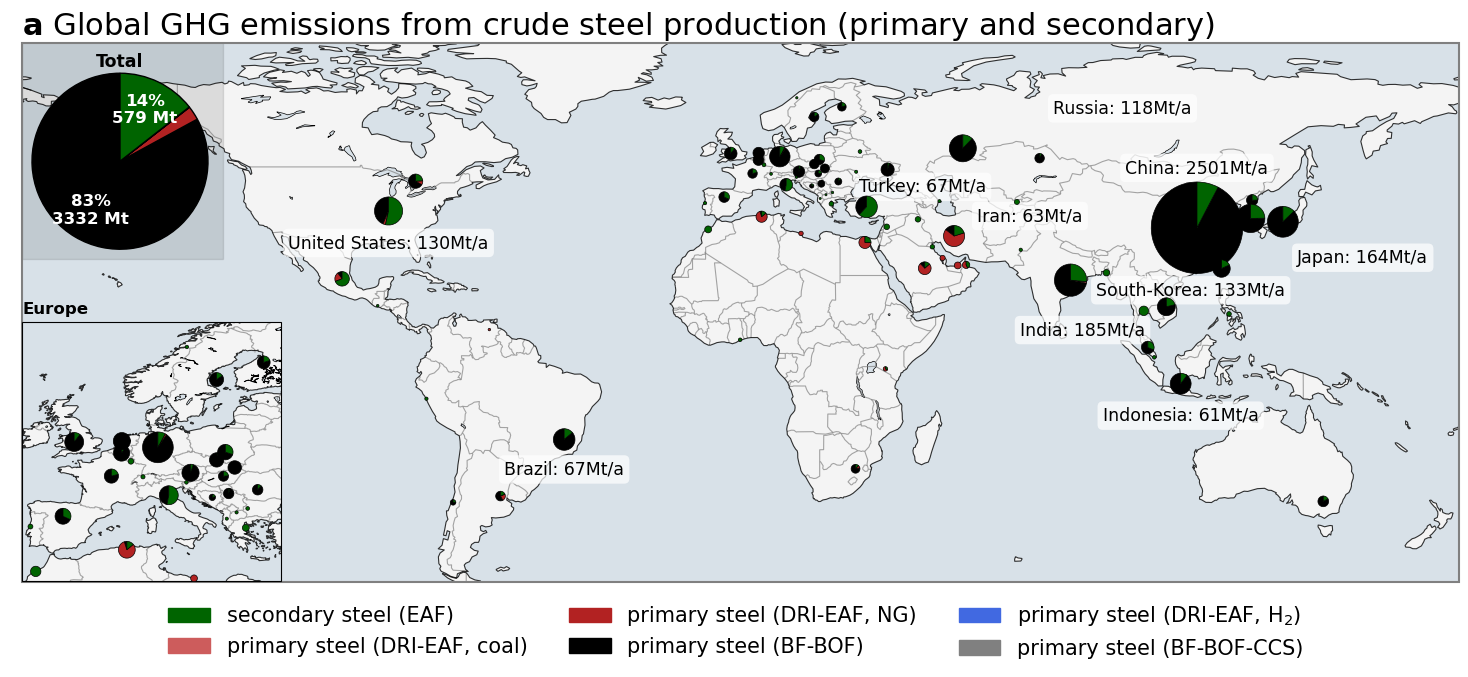

In [36]:
# List of titles and potential columns
titles = ['$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary)']

name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"
pot_cols = [name_to_assess]
plot_steel_map(results_df, pot_cols, subplot=False, titles = titles, division_bubble=20, amount_show_bubble=60, export_figure='annual_global_steel_emissions',
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +23),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (5, -19),
                           'Taiwan': (-12, -19),
                        'Japan': (-9, -20),
                        'South-Korea': (-18, +15),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (+5, -14),
                        'United States': (-8, 0),
                        'Taiwan': (-17, -8),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (65, -6.5))

In [37]:
results_df["Plant_GHG_emissions_Mt_wo_transport"].sum(),results_df["production volume"].sum()

(4017.4292961843903, 1918.9319999999998)

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


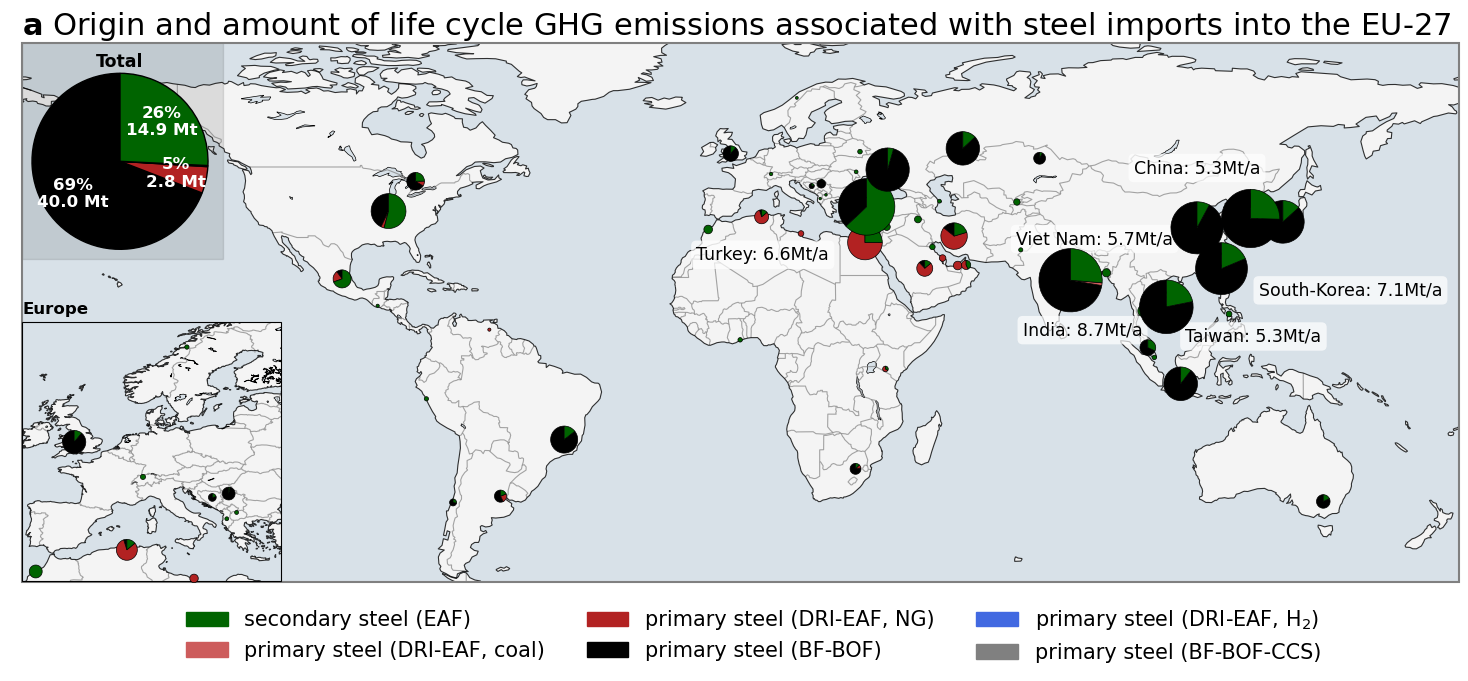

In [38]:
pot_cols = ['Mt_emissions_shift_from_EU']#,'cbam_included_emissions_export_EU', 'cbam_excluded_emissions_export_EU', ]

plot_steel_map(import_df, pot_cols, subplot=False, titles = 
                    [r'$\mathbf{a}$ Origin and amount of life cycle GHG emissions associated with steel imports into the EU-27',
                    #r'$\mathbf{b}$ Shifted GHG emissions from steel production included in CBAM',
                    # r'$\mathbf{c}$ Shifted GHG emissions from steel production excluded in CBAM'
                    ],
               division_bubble=3, amount_show_bubble=[4, 2, 1], non_rounding=1, export_figure='cbam_effectiveness',
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (10, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-9, -20),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-18, -25),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-17, -8),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (70, -5.5),
               custom_autopct=custom_autopct_2
                    )

# Plot Figure 3c

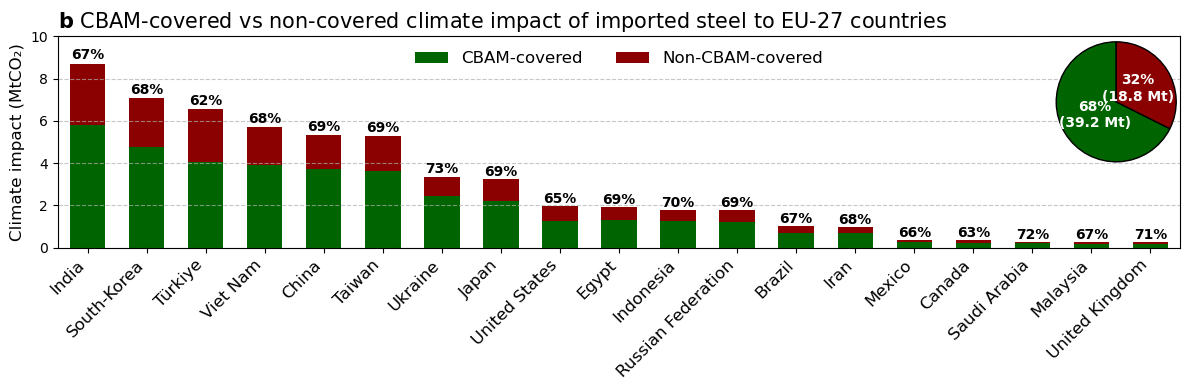

In [42]:
plot_cbam_covered_stacked(import_df, export_figure='cbam_stacked', max_y=10)

### Check CBAM effectiveness for all available (low-carbon) steel production pathways

In [43]:
file_path = "results/results_df_ind.pkl"

columns = ['name', 'year', 'unit', 'location', 'reference product', "database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df_ind = pd.DataFrame(columns=columns) #initialize df to store data in
ei_dbs = [db for db in bd.databases if NAME_REF_DB in str(db) or 'ecoinvent_image' in str(db) ]
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts_ind:
    for db in tqdm(ei_dbs):
        steel_activities = [ act for act in bd.Database(db) 
                             if ', with transport' in act['name'] and ( ('steel production, unalloyed' in act['name'] and
                             'GLO' == act['location']) or ('steel production, converter, unalloyed, only primary steel' in act['name'] and
                             act['location'] in ['RoW', 'World']) or ('primary steel, using direct reduced iron' in act['name'] and
                             act['location'] in ['RoW', 'World']) or ('steel production, electric, low-alloyed, secondary steel, using scrap iron' in act['name'] and
                             act['location'] in ['RoW', 'World']) )] 

        for i, act_sel in enumerate(steel_activities):
            db_name_exch = ""
    
            lca_scores = {}
            lca_scores_contri = {}
    
            for method in MY_METHODS:
                # Initialize LCA for the first method or reuse for subsequent methods
                if i == 0:
                    lca = bw.LCA({act_sel: 1}, method=method)
                    lca.lci()
                    lca.lcia()
                else:
                    if len(MY_METHODS)>1:
                        lca.switch_method(method)
                    lca.redo_lcia({act_sel: 1})
    
                # we need to annotate scope and cbam included info:
                annotate_act_exchanges_with_cbam(act_sel, define_scope_cbam_func=define_scope_cbam,
                                                cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL)
                
                # Store the score for the current method
                lca_scores[f'lca_impact_{method[1]}'] = lca.score
    
                if 'climate change' in str(method):
                    result_array = []
                    for exc in act_sel.exchanges():
                        #print(exc['name'])
                        if exc['type'] == 'technosphere':
                            lca.redo_lcia({exc.input: exc['amount']})
                            result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'], exc['amount']))
                        elif exc['type'] == 'biosphere':
                            # Multiply amount by its CF
                            cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                            result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
        
                    lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array
    
            result = {
                'name': act_sel['name'],
                'reference product': act_sel['reference product'],
                'location': act_sel['location'],
                'unit': act_sel['unit'],
                "database": act_sel['database'],
                'comment': act_sel['comment'],
            }
        
            # update the result dictionary with lca scores
            result.update(lca_scores)
            result.update(lca_scores_contri)

            # Convert the result to a DataFrame
            result_df = pd.DataFrame([result])

            # Determine scope of emissions as well as cbam:
            result_df[['Scope 1', 'Scope 2', 'Scope 3']] = result_df[
                'lca_impact_contri_climate change'].apply(sum_scope_contributions).apply(pd.Series)
            
            result_df[['cbam_true', 'cbam_false']] = result_df[
                'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha 
                                                          if db == NAME_REF_DB else alpha_fut).apply(pd.Series)
        
            # Concatenate the result DataFrame with the main DataFrame
            results_df_ind = pd.concat([results_df_ind, result_df], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df_ind.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df_ind = pickle.load(file)
results_df_ind     

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_32008\1611680267.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_ind = pd.concat([results_df_ind, result_df], ignore_index=True)
100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [17:52<00:00, 178.77s/it]


,name,year,unit,location,reference product,database,lca_impact_climate change,lca_impact_contri_climate change,comment,Scope 1,Scope 2,Scope 3,cbam_true,cbam_false
0,"TGR-BF-BOF, steel production, unalloyed, with ...",NaN,kilogram,GLO,"TGR-BF-BOF steel, unalloyed",ecoinvent_310_reference,2.223085,"[(TGR-BF, iron production, 1.8793257439170714,...","< This dataset is from ecoinvent, modified by ...",0.062709,0.007850,2.152526,1.567995,0.655089
1,"BF-BOF+CCS, steel production, unalloyed, with ...",NaN,kilogram,GLO,"steel, unalloyed",ecoinvent_310_reference,1.659855,"[(BF+CCS, iron production, 1.3160960369713164,...","< This dataset is from ecoinvent, modified by ...",0.062709,0.007850,1.589296,1.123453,0.536403
2,"steel production, electric, low-alloyed, secon...",NaN,kilogram,RoW,"steel, low-alloyed",ecoinvent_310_reference,0.986349,"[(market for aluminium, cast alloy, 0.00062134...",This activity represents the production of sec...,0.056228,0.375347,0.554774,0.515744,0.470604
3,"EW-EAF, steel production, unalloyed, with tran...",NaN,kilogram,GLO,"EW-EAF steel, unalloyed",ecoinvent_310_reference,3.943353,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...","< This dataset is from ecoinvent, modified by ...",0.041439,0.373566,3.528348,2.929336,1.014017
4,"NG-DRI-EAF, steel production, unalloyed, with ...",NaN,kilogram,GLO,"NG-DRI-EAF steel, unalloyed",ecoinvent_310_reference,1.682036,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...","< This dataset is from ecoinvent, modified by ...",0.041439,0.373566,1.267031,1.144536,0.537500
5,"steel production, converter, unalloyed, only p...",NaN,kilogram,RoW,"steel, unalloyed",ecoinvent_310_reference,2.469996,"[(market for basic oxygen furnace dust, 0.0032...",Geography: Data are taken from basic oxygen f...,0.062709,0.039233,2.368054,1.725540,0.744455
6,"H2-DRI-EAF, steel production, unalloyed, with ...",NaN,kilogram,GLO,"H2-DRI-EAF steel, unalloyed",ecoinvent_310_reference,2.264387,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...","< This dataset is from ecoinvent, modified by ...",0.041439,0.373566,1.849383,1.604171,0.660216
7,"steel production, electric, low-alloyed, prima...",NaN,kilogram,RoW,"steel, low-alloyed",ecoinvent_310_reference,3.308747,"[(market for aluminium, cast alloy, 0.00062134...",This activity represents the production of sec...,0.056228,0.375347,2.877172,2.348753,0.959993
8,"TGR-BF-BOF+CCS, steel production, unalloyed, w...",NaN,kilogram,GLO,"TGR-BF-BOF+CCS steel, unalloyed",ecoinvent_310_reference,1.810483,"[(TGR-BF+CCS, iron production, 1.4667234842407...","< This dataset is from ecoinvent, modified by ...",0.062709,0.007850,1.739924,1.242339,0.568144
9,"NG-DRI-EAF+CCS, steel production, unalloyed, w...",NaN,kilogram,GLO,"NG-DRI-EAF+CCS steel, unalloyed",ecoinvent_310_reference,1.293686,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...","< This dataset is from ecoinvent, modified by ...",0.041439,0.373566,0.878681,0.838022,0.455664


In [44]:
results_df_ind.iloc[-2]

name                                EW-EAF, steel production, unalloyed, with tran...
year                                                                              NaN
unit                                                                         kilogram
location                                                                          GLO
reference product                                             EW-EAF steel, unalloyed
database                                         ecoinvent_image_SSP2-RCP26_2050_base
lca_impact_climate change                                                    0.668959
lca_impact_contri_climate change    [(Benzene, 0.0, 1, True, 3.410321381705713e-07...
comment                             < This dataset is from ecoinvent, modified by ...
Scope 1                                                                      0.041439
Scope 2                                                                      0.003576
Scope 3                                               

In [45]:
results_df_ind.iloc[-2]['name']

'EW-EAF, steel production, unalloyed, with transport'

In [46]:
# Convert to DataFrame
data_x = results_df_ind.iloc[-2]['lca_impact_contri_climate change']
df_x = pd.DataFrame(data_x, columns=['Exchange', 'Climate impact', 'Scope', 'CBAM', 'Amount'])
#df_x['spec_impact [kgCO2-eq./FU exchange]'] = df_x['Climate impact']/df_x['Amount']
df_x

,Exchange,Climate impact,Scope,CBAM,Amount
0,Benzene,0.000000,1,True,3.410321e-07
1,Hexachlorobenzene,0.000000,1,True,1.454166e-09
2,Cadmium II,0.000000,1,True,1.141929e-08
3,"Carbon dioxide, fossil",0.041439,1,True,4.143921e-02
4,"Carbon monoxide, fossil",0.000000,1,True,4.452456e-04
5,Chromium III,0.000000,1,True,1.720592e-07
6,Copper ion,0.000000,1,True,7.030558e-08
7,"Dioxins, measured as 2,3,7,8-tetrachlorodibenz...",0.000000,1,True,4.598476e-13
8,"Hydrocarbons, aromatic",0.000000,1,True,7.228433e-05
9,Hydrochloric acid,0.000000,1,True,4.984630e-06


# Plot the result for Figure 4

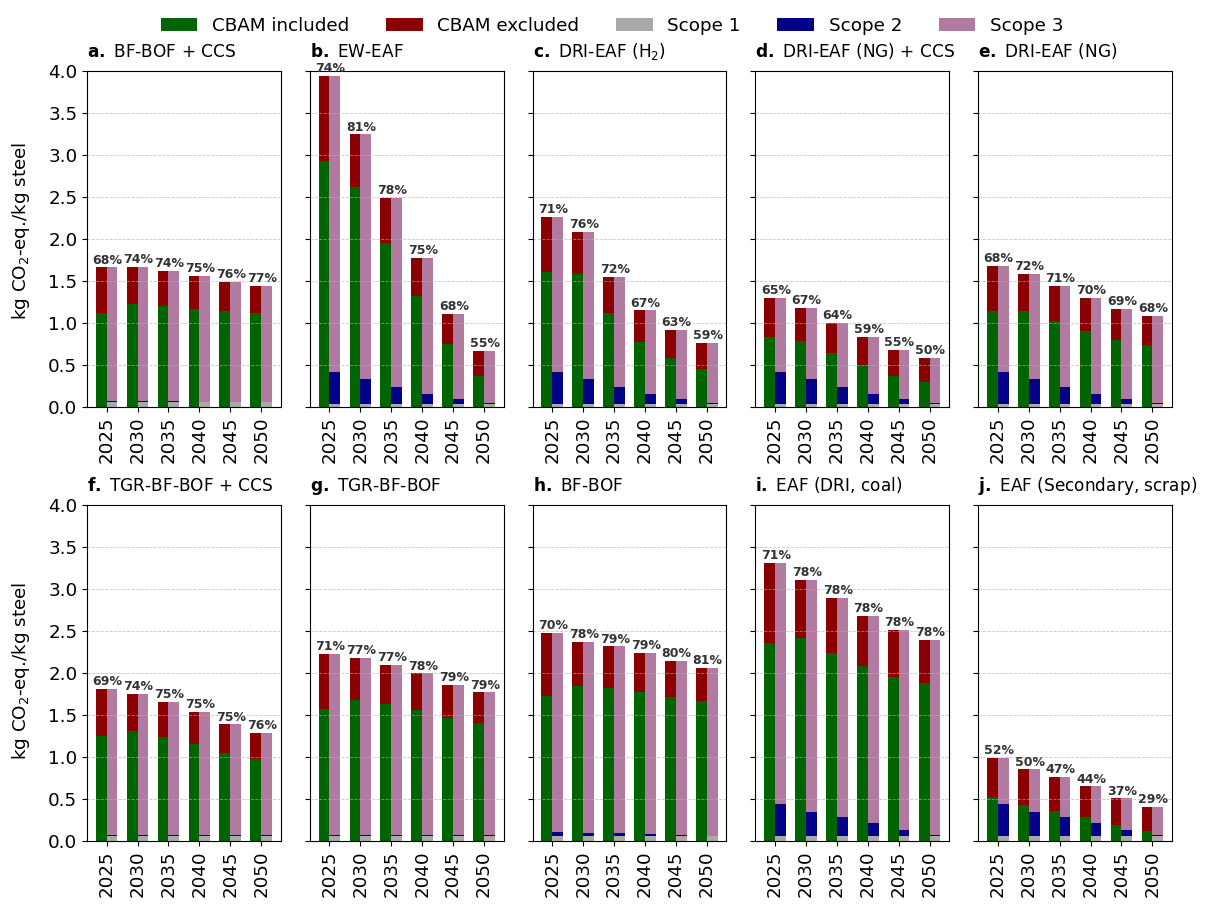

In [47]:
name_mapping_techs = {
    'TGR-BF-BOF+CCS, steel production, unalloyed, with transport': 'TGR-BF-BOF + CCS',
    'EW-EAF, steel production, unalloyed, with transport': 'EW-EAF',
    'steel production, converter, unalloyed, only primary steel, with transport': 'BF-BOF',
    'NG-DRI-EAF, steel production, unalloyed, with transport': 'DRI-EAF (NG)',
    'H2-DRI-EAF, steel production, unalloyed, with transport': 'DRI-EAF (H$_2$)',
    'steel production, electric, low-alloyed, secondary steel, using scrap iron, with transport': 'EAF (Secondary, scrap)',
    'NG-DRI-EAF+CCS, steel production, unalloyed, with transport': 'DRI-EAF (NG) + CCS',
    'steel production, electric, low-alloyed, primary steel, using direct reduced iron, with transport': 'EAF (DRI, coal)',
    'TGR-BF-BOF, steel production, unalloyed, with transport': 'TGR-BF-BOF',
    'BF-BOF+CCS, steel production, unalloyed, with transport': 'BF-BOF + CCS'
}

plot_cbam_scope_stacked(
    results_df_ind=results_df_ind,
    ei_dbs=ei_dbs,
    db_label_map=db_label_map,
    name_mapping_techs=name_mapping_techs
)

results_df_ind[['cbam_true_efactor', 'cbam_false_efactor']] = results_df_ind[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions_emission_factor, alpha=alpha_fut).apply(pd.Series)

plot_cbam_scope_stacked(
    results_df_ind=results_df_ind,
    ei_dbs=ei_dbs,
    db_label_map=db_label_map,
    name_mapping_techs=name_mapping_techs,
    name_cbam_true='cbam_true_efactor',
    name_cbam_false='cbam_false_efactor',
    output_path='figs/steel_cbam_scope_stacked_efactor.png',
)

___
### 9. Prospective analysis

Two scenarios in 2C world:
* Plants with secondary EAF and CCS
* Plants with secondary EAF and with H2-DRI

  
Also, we filter out older plants and integrate all low-carbon projects provided in https://www.industrytransition.org/green-steel-tracker/

In [48]:
plants_mod_future['Capacity operating status'].unique()

array(['Announced', 'Construction', 'Operating',
       'Finalized (research & testing)', 'operating',
       'operating pre-retirement', 'mothballed', 'retired',
       'construction', 'announced', 'cancelled'], dtype=object)

In [49]:
valid_future_statuses = [
    'Operating', 'operating',
    'Announced', 'announced',
    'Construction', 'construction',
    'Finalized (research & testing)'
]

plants_mod_future = plants_mod_future[
    plants_mod_future['Capacity operating status'].isin(valid_future_statuses)
]
plants_mod_future['Capacity operating status'].value_counts()

Capacity operating status
operating                         783
Announced                          33
announced                          27
Construction                       13
construction                       11
Operating                           3
Finalized (research & testing)      3
Name: count, dtype: int64

In [50]:
start_year = 1950 #exclude plants where years are before this one
plants_mod_future = plants_mod_future[ (plants_mod_future['Start date']>start_year) & (plants_mod_future['Start date']<=FUTURE_YEAR) ]
plants_mod_future['Start date'].describe()

count     723.000000
mean     1996.835408
std        20.743634
min      1951.000000
25%      1982.000000
50%      2001.000000
75%      2012.000000
max      2033.000000
Name: Start date, dtype: float64

In [51]:
image_file = pd.read_excel(r"data\full data\image_SSP2-RCP26.xlsx")
image_file_steel = image_file[ (image_file['Variable'].str.contains('Production|Industry|Iron and Steel', regex=False) ) & 
            (image_file['Region']!='World') ]
scrap_primary = image_file_steel[ (image_file_steel['Variable'] == 'Production|Industry|Iron and Steel|EAF scrap') | (image_file_steel['Variable'] == 'Production|Industry|Iron and Steel|Primary')]
scrap_primary.groupby("Variable").sum()[str(FUTURE_YEAR)]

Variable
Production|Industry|Iron and Steel|EAF scrap     702.041904
Production|Industry|Iron and Steel|Primary      1446.449436
Name: 2040, dtype: float64

In [52]:
scrap_primary.groupby("Variable").sum()[str(FUTURE_YEAR)].sum()

2148.4913406074047

In [53]:
primary_steel_image_future = 1446.449436 #image_SSP2-RCP26.
secondary_steel_image_future = 702.041904 #image_SSP2-RCP26.

In [54]:
primary_steel_image_future/(primary_steel_image_future+secondary_steel_image_future)

0.6732395933231922

In [55]:
factor_sec = secondary_steel_image_future/plants_mod_future['EAF steel production'].sum()
plants_mod_future['EAF steel production'] *= factor_sec
plants_mod_future['EAF steel production'].sum()

702.041904

In [56]:
cols_prim = ['BOF steel production',
 #'EAF steel production',
 'EAF steel production (DRI, coal)',
 'EAF steel production (DRI, NG)',
 'OHF steel production',
 #'BF production',
 #'DRI production',
'steel production']

cols = ['BOF steel production',
 'EAF steel production',
 'EAF steel production (DRI, coal)',
 'EAF steel production (DRI, NG)',
 'OHF steel production',
 #'BF production',
 #'DRI production',
'steel production']

factor = primary_steel_image_future/plants_mod_future[cols_prim].sum().sum()

plants_mod_future[cols_prim] = plants_mod_future[cols_prim].multiply(factor)
plants_mod_future[cols_prim].sum(),plants_mod_future[cols_prim].sum().sum()

(BOF steel production                1324.681463
 EAF steel production (DRI, coal)       0.842857
 EAF steel production (DRI, NG)        74.267884
 OHF steel production                   0.000000
 steel production                      46.657231
 dtype: float64,
 1446.4494360000003)

___
### 9.1 Prospective analysis (BF-BOF-CCS)
### Now, we will have to make some assumptions about the future of steel production, we take the IMAGE 2C model


In [57]:
#exclude iron making
plants_mod_future = plants_mod_future[~plants_mod_future['steel_or_iron_production'].str.contains('iron', case=False, na=False)]
plants_mod_future['Capacity operating status'].value_counts()

Capacity operating status
operating       628
Announced        15
announced        11
Construction      8
construction      4
Name: count, dtype: int64

In [58]:
if create_new_steel_db_future:
    ref_db_w = w.extract_brightway2_databases(NAME_REF_DB, add_properties=False, add_identifiers=False)
    ref_db_w_2040 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2040_base', add_properties=False, add_identifiers=False)
    bio_db_w = w.extract_brightway2_databases(BIOSPHERE_DB, add_properties=False, add_identifiers=False)

    database_sel = {NAME_REF_DB:ref_db_w,
                    BIOSPHERE_DB:bio_db_w,
                    'ecoinvent_image_SSP2-RCP26_2040_base':ref_db_w_2040
                   }

Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 26110/26110 [00:01<00:00, 26003.87it/s]


Adding exchange data to activities


100%|████████████████████████████████████████████████████████████████████████| 804790/804790 [03:16<00:00, 4095.22it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 26110/26110 [00:10<00:00, 2577.15it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35222/35222 [00:00<00:00, 41407.74it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1018453/1018453 [02:52<00:00, 5888.49it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35222/35222 [00:07<00:00, 4608.63it/s]


Getting activity data


100%|███████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<00:00, 74249.03it/s]


Adding exchange data to activities


0it [00:00, ?it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<00:00, 581051.04it/s]


In [59]:
new_steel_activities = []
db_name_future = "steel_db_future"
start_idx = 0
all_names = []

if create_new_steel_db_future:
    if db_name_future in list(bw.databases):
        del bw.databases[db_name_future]
    
    #create_database(db_name_future)
    counter = 1
    for counter, (index, row) in enumerate(plants_mod_future.iterrows(), start=1):
        if index < start_idx:
            continue  # Skip until we reach the desired index
            
        if row['steel_or_iron_production'] == 'both' or row['steel_or_iron_production'] == 'steel':
            sum_end_uses = row.filter(regex='steel production')
        elif row['steel_or_iron_production'] == 'iron':
            sum_end_uses = row.filter(like=' production').filter(regex='^(?!.*(steel|Company)).*$')
        else:
            raise ValueError("ERROR")
            
        sum_end_uses = sum_end_uses.dropna()[sum_end_uses > 0]
        row.fillna(np.nan,inplace=True)
        
        print(f"{counter}/{len(plants_mod_future)}", end="\r", flush=True)
        counter += 1

        for k, end_use in enumerate(list(sum_end_uses.index)):
            plant_name = row['Plant name (English)_x']
            tech_key = end_use
        
            if pd.isna(plant_name):  # Future or current plant with unknown name
                tech_key = f"{row['steel_or_iron_production']}-{row['steel_decarb_classification']}"
                plant_name = f"{row['Project name']}_{row['Internal ID']}"
        
            match_activity = dict_acts_future_dri[row["steel_classification"]].get(tech_key)
        
            # Assumes all plants here are online in FUTURE_YEAR
            matched_database = match_year_to_database(FUTURE_YEAR)
            db_sel = database_sel[matched_database]
    
            # Get iso2 location using pycountry
            iso2 = country_to_iso2(row['Country/Area'])

            # Make new activity name and dictionary data + regionalize exchanges of this activity, which are processed in the next step
            new_act, activity_to_adapt, new_code = create_regionalized_activity(
                                db_sel,
                                match_activity,
                                iso2,
                                row,
                                end_use,
                                db_name,
                                plant_name,
                                FUTURE_YEAR
                            )
                
            if new_act['name'] in all_names:
                print(f"WARNING: Activity already exists, skipping plant name with ID: '{new_act['name']}', '{row['Plant ID']}'")
                continue
                
            all_names.append(new_act['name'])

            new_act['exchanges'] = process_exchanges(activity_to_adapt, row, matched_database, db_name_future, iso2, db_sel, new_code)      

            # add exchanges to transport the steel
            transport_ex = add_transport_exchanges(row['Continent'], db_sel, matched_database, km_transport_train=500)     
            new_act['exchanges'].extend(transport_ex)
            
            new_steel_activities.append(new_act)

Vacuuming database 


In [60]:
if create_new_steel_db_future:
    process_import(db_name_future, new_steel_activities)

    annotate_exchanges_with_cbam(
        db_name=db_name_future,
        define_scope_cbam_func=define_scope_cbam,
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL
    )

Applying strategy: add_database_name
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 2.21 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
711 datasets
57105 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\lca_steel_sector_cbam.27d78f50af11f772309a5a15dc8c3210\output\db-matching-steel_db_future-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Title: Writing activities to SQLite3 database:
  Started: 09/10/2025 18:44:12
  Finished: 09/10/2025 18:44:22
  Total time elapsed: 00:00:10
  CPU %: 80.90
  Memory %: 30.24
Created database: steel_db_future


## Now, we can calculate LCA results of this prospective scenario for hydrogen-based low-carbon steel-making:

In [61]:
file_path = "results/results_df_future.pkl"

columns = ['name', 'year', 'unit', 'country', 'reference product','production volume',"database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df_future = pd.DataFrame(columns=columns) #initialize df to store data in

start_idx=0
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts_future:  
    acts = list(bw.Database(db_name_future))
    for i, act_sel in enumerate(tqdm(acts)):
        if i < start_idx:
            continue  # Skip until we reach the desired index
            
        db_name_exch = ""

        lca_scores = {}
        lca_scores_contri = {}

        for method in MY_METHODS:
            # Initialize LCA for the first method or reuse for subsequent methods
            if i == 0:
                lca = bw.LCA({act_sel: 1}, method=method)
                lca.lci()
                lca.lcia()
            else:
                if len(MY_METHODS)>1:
                    lca.switch_method(method)
                lca.redo_lcia({act_sel: 1})
            
            # Store the score for the current method
            lca_scores[f'lca_impact_{method[1]}'] = lca.score

            if 'climate change' in str(method) and contri_future:
                result_array = []
                for exc in act_sel.exchanges():
                    if exc['type'] == 'technosphere':
                        lca.redo_lcia({exc.input: exc['amount']})
                        result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'],exc['amount']))
                    elif exc['type'] == 'biosphere':
                        # Multiply amount by its CF
                        cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                        result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
    
                lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array

        result = {
            'name': act_sel['name'],
            'reference product': act_sel['reference product'],
            'country':act_sel['location'],
            'location': act_sel['location'],
            'production volume': act_sel['production volume'],
            'unit': act_sel['unit'],
            "database": act_sel['database'],
            "initial name": act_sel['name'].split(" for facility in")[0],
            'comment': act_sel['comment'],
            'year': int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act_sel['name'])) else None,
            'latitude': act_sel['comment'].split("latitude:")[1].split(",")[0],
            'longitude': act_sel['comment'].split("longitude:")[1].split(",")[0],
            'power_source': act_sel['comment'].split("power source:")[1].split(",")[0],
        }
    
        # update the result dictionary with lca scores
        result.update(lca_scores)
        result.update(lca_scores_contri)

        # Convert the result to a DataFrame
        result = pd.DataFrame([result])
    
        # Concatenate the result DataFrame with the main DataFrame
        results_df_future = pd.concat([results_df_future, result], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df_future.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df_future = pickle.load(file)        

# make lat and lon numeric
results_df_future['latitude'] = pd.to_numeric(results_df_future['latitude'], errors='coerce')
results_df_future['longitude'] = pd.to_numeric(results_df_future['longitude'], errors='coerce')

# Now, we also apply a function that excludes the transport exchanges we added, as not all steel will be imported to the EU
results_df_future["lca_impact_climate change_wo_transport"] = results_df_future['lca_impact_contri_climate change'].apply(sum_exchanges_wo_transport)
results_df_future["Plant_GHG_emissions_Mt_wo_transport"] = results_df_future['production volume']*results_df_future['lca_impact_climate change_wo_transport']

#results_df_future = pd.merge(results_df_future, df_countries, on='location') # add lat lon info
# Add a new column to the DataFrame to classify countries as European or Non-European
results_df_future['region'] = results_df_future['location'].apply(lambda x: 'European' if x in european_countries else 'Non-European')
results_df_future["Plant_GHG_emissions_Mt"] = results_df_future['production volume']*results_df_future['lca_impact_climate change']
results_df_future['commodity_type'] = results_df_future['initial name'].map(dict_types)
#exclude iron making
results_df_future = results_df_future[~results_df_future['initial name'].str.contains('iron', case=False, na=False)]
results_df_future.sort_values(by="Plant_GHG_emissions_Mt", ascending=False)

  0%|                                                                                          | 0/711 [00:00<?, ?it/s]C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_32008\439910984.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_future = pd.concat([results_df_future, result], ignore_index=True)
100%|████████████████████████████████████████████████████████████████████████████████| 711/711 [31:45<00:00,  2.68s/it]


,name,year,unit,country,reference product,production volume,database,lca_impact_climate change,lca_impact_contri_climate change,location,initial name,comment,latitude,longitude,power_source,lca_impact_climate change_wo_transport,Plant_GHG_emissions_Mt_wo_transport,region,Plant_GHG_emissions_Mt,commodity_type
275,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,CN,"H2-DRI-EAF steel, unalloyed",84.780,steel_db_future,3.086434,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.814130,112.897377,grid,2.966721,251.518580,Non-European,261.667874,"primary steel (DRI-EAF, H$_2$)"
11,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,CN,"H2-DRI-EAF steel, unalloyed",79.983,steel_db_future,3.086434,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.747782,111.967343,grid,2.966721,237.287221,Non-European,246.862250,"primary steel (DRI-EAF, H$_2$)"
533,"H2-DRI-EAF, steel production, low-alloyed for ...",2040,kilogram,CN,"H2-DRI-EAF steel, low-alloyed",41.914,steel_db_future,3.432110,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, low-alloyed","< This dataset is from ecoinvent, modified by ...",37.752351,115.184798,grid,3.312397,138.835808,Non-European,143.853472,"primary steel (DRI-EAF, H$_2$)"
43,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,CN,"H2-DRI-EAF steel, unalloyed",18.061,steel_db_future,3.086434,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",24.385304,109.379630,grid,2.966721,53.581942,Non-European,55.744084,"primary steel (DRI-EAF, H$_2$)"
515,"H2-DRI-EAF, steel production, low-alloyed for ...",2040,kilogram,CN,"H2-DRI-EAF steel, low-alloyed",15.299,steel_db_future,3.432110,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, low-alloyed","< This dataset is from ecoinvent, modified by ...",31.416230,121.440087,grid,3.312397,50.676362,Non-European,52.507856,"primary steel (DRI-EAF, H$_2$)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,"steel production, electric, low-alloyed for fa...",2040,kilogram,FR,"steel, low-alloyed",0.614,steel_db_future,0.227981,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",FR,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",50.398171,3.561712,grid,0.207570,0.127448,European,0.139980,secondary steel (EAF)
545,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,ID,"H2-DRI-EAF steel, unalloyed",0.944,steel_db_future,0.042518,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",ID,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",-3.339296,115.927125,grid,-0.077195,-0.072872,Non-European,0.040137,"primary steel (DRI-EAF, H$_2$)"
136,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,ID,"H2-DRI-EAF steel, unalloyed",0.925,steel_db_future,0.042518,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",ID,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",-6.282658,107.117683,grid,-0.077195,-0.071406,Non-European,0.039329,"primary steel (DRI-EAF, H$_2$)"
423,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,VE,"H2-DRI-EAF steel, unalloyed",0.272,steel_db_future,0.064720,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",VE,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",8.259073,-62.841126,grid,-0.074853,-0.020360,Non-European,0.017604,"primary steel (DRI-EAF, H$_2$)"


In [62]:
# Determine scope of emissions as well as cbam:
#if contri_future:
results_df_future[['Scope 1', 'Scope 2', 'Scope 3']] = results_df_future[
    'lca_impact_contri_climate change'].apply(sum_scope_contributions).apply(pd.Series)

results_df_future[['cbam_true', 'cbam_false']] = results_df_future[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha_fut).apply(pd.Series)

results_df_future['cbam_true_total_cc'] = results_df_future['cbam_true'] * results_df_future['production volume']
results_df_future['cbam_false_total_cc'] = results_df_future['cbam_false'] * results_df_future['production volume']

results_df_future['share_cbam_covered'] = results_df_future['cbam_true_total_cc']/(results_df_future['cbam_true_total_cc'] + results_df_future['cbam_false_total_cc'])
#this can happen due to negative emissions...
results_df_future.loc[results_df_future['share_cbam_covered'] < 0, 'share_cbam_covered'] = 1

print(results_df_future.share_cbam_covered.describe(),results_df_future['cbam_true_total_cc'].sum()/(results_df_future['cbam_true_total_cc'].sum() +results_df_future['cbam_false_total_cc'].sum()) )

count    711.000000
mean       0.676166
std        0.140391
min        0.086941
25%        0.594716
50%        0.641769
75%        0.793747
max        1.000000
Name: share_cbam_covered, dtype: float64 0.8010516640359375


In [63]:
results_df_future[['share_cbam_covered', 'country']].groupby('country').mean().sort_values(by='share_cbam_covered').loc['CN']

share_cbam_covered    0.739262
Name: CN, dtype: float64

In [64]:
results_df_future.sort_values(by='share_cbam_covered')

,name,year,unit,country,reference product,production volume,database,lca_impact_climate change,lca_impact_contri_climate change,location,...,Plant_GHG_emissions_Mt,commodity_type,Scope 1,Scope 2,Scope 3,cbam_true,cbam_false,cbam_true_total_cc,cbam_false_total_cc,share_cbam_covered
193,"H2-DRI-EAF, steel production, low-alloyed for ...",2040,kilogram,ID,"H2-DRI-EAF steel, low-alloyed",5.666,steel_db_future,0.388194,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",ID,...,2.199508,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.538997,0.851018,0.033750,0.354444,0.191227,2.008282,0.086941
644,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,VN,"H2-DRI-EAF steel, unalloyed",6.015,steel_db_future,0.375836,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",VN,...,2.260654,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.220840,0.520503,0.046402,0.329434,0.279106,1.981548,0.123463
255,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,VN,"H2-DRI-EAF steel, unalloyed",2.686,steel_db_future,0.375836,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",VN,...,1.009496,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.220840,0.520503,0.046402,0.329434,0.124635,0.884861,0.123463
354,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,VN,"H2-DRI-EAF steel, unalloyed",0.472,steel_db_future,0.375836,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",VN,...,0.177395,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.220840,0.520503,0.046402,0.329434,0.021902,0.155493,0.123463
556,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,TH,"H2-DRI-EAF steel, unalloyed",1.889,steel_db_future,0.362326,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",TH,...,0.684433,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.220840,0.506993,0.046402,0.315924,0.087653,0.596780,0.128066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,AR,"H2-DRI-EAF steel, unalloyed",2.680,steel_db_future,0.056860,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",AR,...,0.152385,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.547493,0.528180,-0.280251,0.337111,-0.751073,0.903458,1.000000
423,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,VE,"H2-DRI-EAF steel, unalloyed",0.272,steel_db_future,0.064720,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",VE,...,0.017604,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.547493,0.536040,-0.280251,0.344972,-0.076228,0.093832,1.000000
243,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,ID,"H2-DRI-EAF steel, unalloyed",19.360,steel_db_future,0.042518,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",ID,...,0.823147,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.538997,0.505342,-0.271755,0.314273,-5.261179,6.084325,1.000000
545,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,ID,"H2-DRI-EAF steel, unalloyed",0.944,steel_db_future,0.042518,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",ID,...,0.040137,"primary steel (DRI-EAF, H$_2$)",0.076173,-0.538997,0.505342,-0.271755,0.314273,-0.256537,0.296674,1.000000


In [65]:
results_df_future[['cbam_true_efactor', 'cbam_false_efactor']] = results_df_future[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions_emission_factor, alpha=alpha_fut).apply(pd.Series)

results_df_future['cbam_true_total_cc_efactor'] = results_df_future['cbam_true_efactor'] * results_df_future['production volume']
results_df_future['cbam_false_total_cc_efactor'] = results_df_future['cbam_false_efactor'] * results_df_future['production volume']
results_df_future['share_cbam_covered_efactor'] = results_df_future['cbam_true_total_cc_efactor']/(results_df_future['cbam_true_total_cc_efactor'] + results_df_future['cbam_false_total_cc_efactor'])

#this can happen due to negative emissions...
results_df_future.loc[results_df_future['share_cbam_covered_efactor'] < 0, 'share_cbam_covered_efactor'] = 1

results_df_future['share_cbam_covered_efactor'].describe(), results_df_future['cbam_true_total_cc_efactor'].sum()/(results_df_future['cbam_true_total_cc_efactor'].sum() +results_df_future['cbam_false_total_cc_efactor'].sum())

hydrogen production, gaseous, 30 bar, from PEM electrolysis, solar PV ground-mounted, global cf [0.175] ('hydrogen production, gaseous, 30 bar, from PEM electrolysis', 83.16831683168317, 2) 1.9899447279887 0
hydrogen production, gaseous, 30 bar, from PEM electrolysis, solar PV ground-mounted, global cf [0.175] ('hydrogen production, gaseous, 30 bar, from PEM electrolysis', 83.16831683168317, 2) 1.9899447279887 0
hydrogen production, gaseous, 30 bar, from PEM electrolysis, solar PV ground-mounted, global cf [0.175] ('hydrogen production, gaseous, 30 bar, from PEM electrolysis', 83.16831683168317, 2) 1.9899447279887 0
hydrogen production, gaseous, 30 bar, from PEM electrolysis, solar PV ground-mounted, global cf [0.175] ('hydrogen production, gaseous, 30 bar, from PEM electrolysis', 83.16831683168317, 2) 1.9899447279887 0
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 10.872286744095529 11
hydrogen production, gaseous, 30 bar, from PEM electrolysis, so

(count    711.000000
 mean       0.646016
 std        0.160590
 min        0.086941
 25%        0.540094
 50%        0.608466
 75%        0.793747
 max        1.000000
 Name: share_cbam_covered_efactor, dtype: float64,
 0.7861631707408089)

In [66]:
total_emissions = results_df_future['Plant_GHG_emissions_Mt_wo_transport'].sum()
total_production = results_df_future['production volume'].sum()
emissions_intensity = total_emissions / total_production

print(f"Total GHG emissions (without transport): {total_emissions:.2f} Mt")
print(f"Total production volume: {total_production:.2f}")
print(f"Emissions intensity: {emissions_intensity:.2f} kgCO2-eq./kg steel")

Total GHG emissions (without transport): 3585.62 Mt
Total production volume: 2148.49
Emissions intensity: 1.67 kgCO2-eq./kg steel


## Calculation hydrogen requirements

In [67]:
## Calculation of hydrogen requirements for H₂-DRI-EAF steel production
# Hydrogen needed per kg of steel (kg H₂ per kg steel)
h2_per_kg_steel = 0.06652320961866715

# Total steel production volume (in Mt) for H₂-DRI-EAF routes
steel_production_Mt = (
    results_df_future.groupby('initial name').sum().loc['H2-DRI-EAF, steel production, low-alloyed']['production volume'] +
    results_df_future.groupby('initial name').sum().loc['H2-DRI-EAF, steel production, unalloyed']['production volume']
)

# Convert steel production from Mt to kg
steel_production_kg = steel_production_Mt * 1e9  # 1 Mt = 1e9 kg

# Calculate total hydrogen demand in Mt
hydrogen_demand_Mt = h2_per_kg_steel * steel_production_kg / 1e9

# Output result
f"Estimated hydrogen demand for H2-DRI-EAF steel production is approximately {hydrogen_demand_Mt:.2f} Mt H2."

'Estimated hydrogen demand for H₂-DRI-EAF steel production is approximately 95.72 Mt H₂.'

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


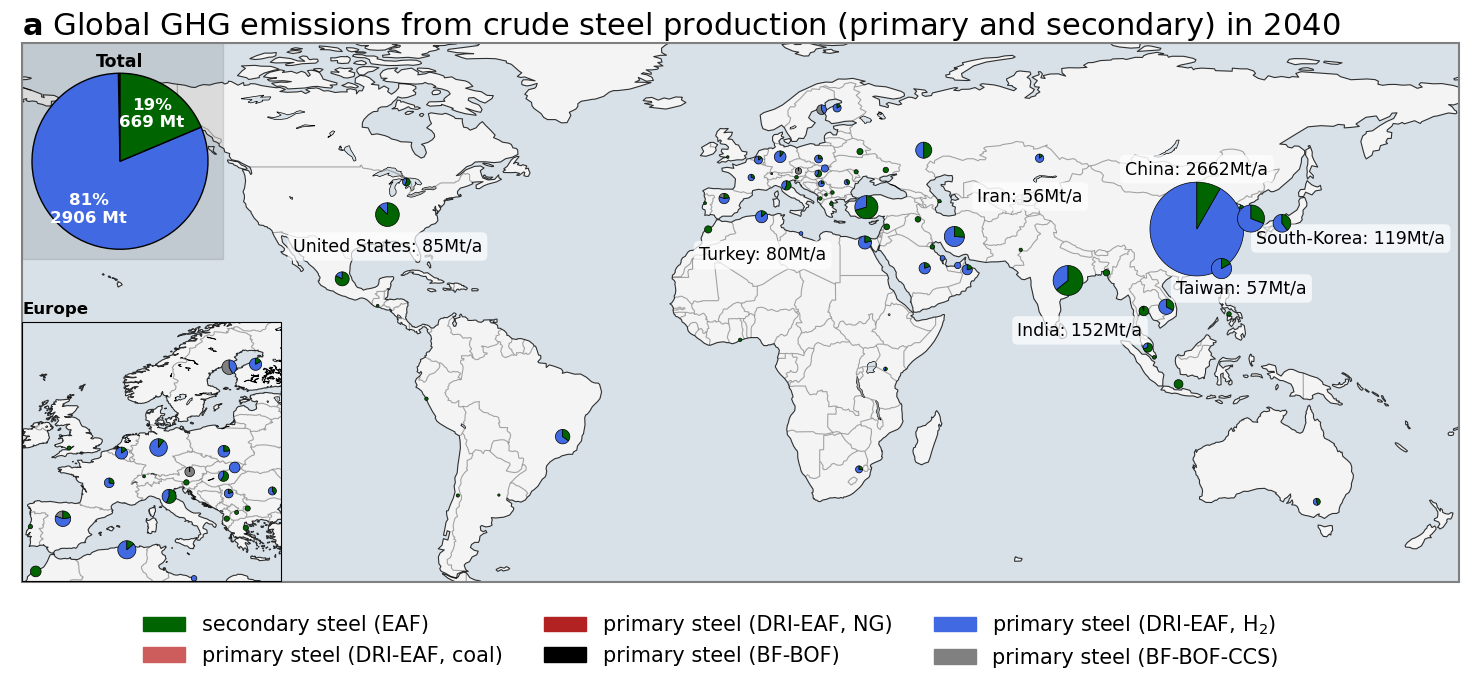

In [68]:
# List of titles and potential columns
titles = [r'$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary) in 2040']

name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"
pot_cols = [name_to_assess]
plot_steel_map(results_df_future, pot_cols, subplot=False, titles = titles, division_bubble=20, amount_show_bubble=50, export_figure='annual_global_steel_emissions_2040_h2_dri', 
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (10, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-9, -20),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-5, -25),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-5, -5),
                           'Egypt': (-14, 0)
                          }, 
               pos_legend_false_subplot = (80, -9.0))

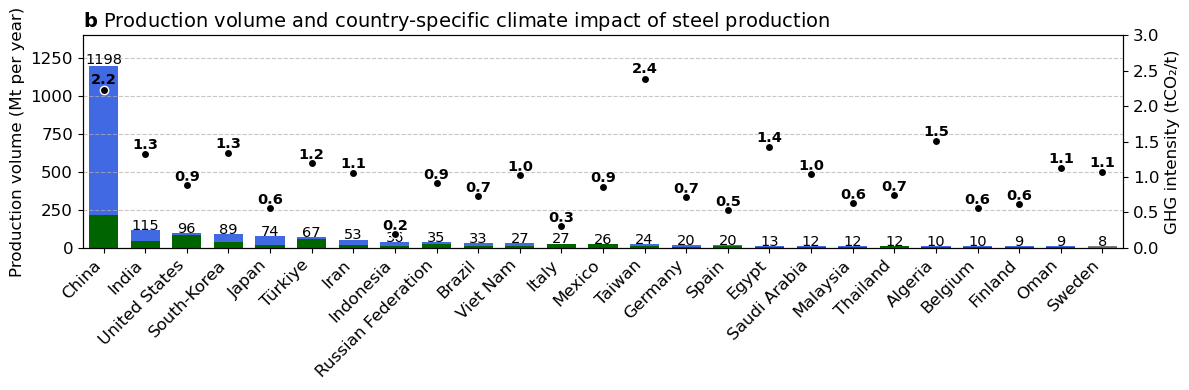

In [69]:
for col in ['production volume']:
    plot_steel_production(results_df_future, production_col=col, export_figure='prod_fig_intensity_h2_dri',max_y=1400)

___
### 9.2 Prospective analysis: low-carbon primary steel-making using CCS instead

In [70]:
if create_new_steel_db_future_ccs:
    ref_db_w = w.extract_brightway2_databases(NAME_REF_DB, add_properties=False, add_identifiers=False)
    ref_db_w_2040 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2040_base', add_properties=False, add_identifiers=False)
    bio_db_w = w.extract_brightway2_databases(BIOSPHERE_DB, add_properties=False, add_identifiers=False)

    database_sel = {NAME_REF_DB:ref_db_w,
                    BIOSPHERE_DB:bio_db_w,
                    'ecoinvent_image_SSP2-RCP26_2040_base':ref_db_w_2040
                   }


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 26110/26110 [00:00<00:00, 40531.38it/s]


Adding exchange data to activities


100%|████████████████████████████████████████████████████████████████████████| 804790/804790 [03:50<00:00, 3486.70it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 26110/26110 [00:09<00:00, 2650.52it/s]


Getting activity data


100%|█████████████████████████████████████████████████████████████████████████| 35222/35222 [00:00<00:00, 80095.65it/s]


Adding exchange data to activities


100%|██████████████████████████████████████████████████████████████████████| 1018453/1018453 [02:49<00:00, 6005.28it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 35222/35222 [00:09<00:00, 3734.27it/s]


Getting activity data


100%|███████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<00:00, 68957.08it/s]


Adding exchange data to activities


0it [00:00, ?it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<00:00, 278742.67it/s]


In [71]:
new_steel_activities = []
db_name_future_ccs = "steel_db_future_ccs"
start_idx = 0

all_names = []

if create_new_steel_db_future_ccs:
    if db_name_future_ccs in list(bw.databases):
        del bw.databases[db_name_future_ccs]
    
    #create_database(db_name_future_ccs)
    counter = 1
    for counter, (index, row) in enumerate(plants_mod_future.iterrows(), start=1):
        if index < start_idx:
            continue  # Skip until we reach the desired index
            
        if row['steel_or_iron_production'] == 'both' or row['steel_or_iron_production'] == 'steel':
            sum_end_uses = row.filter(regex='steel production')
        elif row['steel_or_iron_production'] == 'iron':
            sum_end_uses = row.filter(like=' production').filter(regex='^(?!.*(steel|Company)).*$')
        else:
            raise ValueError("ERROR")
            
        sum_end_uses = sum_end_uses.dropna()[sum_end_uses > 0]
        row.fillna(np.nan,inplace=True)
        
        print(f"{counter}/{len(plants_mod_future)}", end="\r", flush=True)
        counter += 1

        for k, end_use in enumerate(list(sum_end_uses.index)):
            plant_name = row['Plant name (English)_x']
            tech_key = end_use
        
            if pd.isna(plant_name):  # Future or current plant with unknown name
                tech_key = f"{row['steel_or_iron_production']}-{row['steel_decarb_classification']}"
                plant_name = f"{row['Project name']}_{row['Internal ID']}"
        
            match_activity = dict_acts_future_ccs[row["steel_classification"]].get(tech_key)
        
            # Assumes all plants here are online in FUTURE_YEAR
            matched_database = match_year_to_database(FUTURE_YEAR)
            db_sel = database_sel[matched_database]
    
            # Get iso2 location using pycountry
            iso2 = country_to_iso2(row['Country/Area'])
                
            # Make new activity name and dictionary data + regionalize exchanges of this activity, which are processed in the next step
            new_act, activity_to_adapt, new_code = create_regionalized_activity(
                                db_sel,
                                match_activity,
                                iso2,
                                row,
                                end_use,
                                db_name,
                                plant_name,
                                FUTURE_YEAR
                            )
            
            if new_act['name'] in all_names:
                print(f"WARNING: Activity already exists, skipping plant name with ID: '{new_act['name']}', '{row['Plant ID']}'")
                continue
                
            all_names.append(new_act['name'])
            
            new_act['exchanges'] = process_exchanges(activity_to_adapt, row, matched_database, db_name_future_ccs, iso2, db_sel, new_code)     

            # add exchanges to transport the steel
            transport_ex = add_transport_exchanges(row['Continent'], db_sel, matched_database, km_transport_train=500)     
            new_act['exchanges'].extend(transport_ex)
            
            new_steel_activities.append(new_act)

Vacuuming database 


In [72]:
if create_new_steel_db_future_ccs:
    process_import(db_name_future_ccs, new_steel_activities)

    annotate_exchanges_with_cbam(
        db_name=db_name_future_ccs,
        define_scope_cbam_func=define_scope_cbam,
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL
    )

Applying strategy: add_database_name
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 2.70 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
711 datasets
57905 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\lca_steel_sector_cbam.27d78f50af11f772309a5a15dc8c3210\output\db-matching-steel_db_future_ccs-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Title: Writing activities to SQLite3 database:
  Started: 09/10/2025 21:04:32
  Finished: 09/10/2025 21:04:41
  Total time elapsed: 00:00:08
  CPU %: 89.00
  Memory %: 41.94
Created database: steel_db_future_ccs


In [73]:
file_path = "results/results_df_future_ccs.pkl"

columns = ['name', 'year', 'unit', 'country', 'reference product','production volume',"database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df_future_ccs = pd.DataFrame(columns=columns) #initialize df to store data in

start_idx=0
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts_future_ccs:  
    acts = list(bw.Database(db_name_future_ccs))
    for i, act_sel in enumerate(tqdm(acts)):
        if i < start_idx:
            continue  # Skip until we reach the desired index
            
        db_name_exch = ""

        lca_scores = {}
        lca_scores_contri = {}

        for method in MY_METHODS:
            # Initialize LCA for the first method or reuse for subsequent methods
            if i == 0:
                lca = bw.LCA({act_sel: 1}, method=method)
                lca.lci()
                lca.lcia()
            else:
                if len(MY_METHODS)>1:
                    lca.switch_method(method)
                lca.redo_lcia({act_sel: 1})
            
            # Store the score for the current method
            lca_scores[f'lca_impact_{method[1]}'] = lca.score

            if 'climate change' in str(method) and contri_future_ccs:
                result_array = []
                for exc in act_sel.exchanges():
                    if exc['type'] == 'technosphere':
                        lca.redo_lcia({exc.input: exc['amount']})
                        result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'], exc['amount']))
                    elif exc['type'] == 'biosphere':
                        # Multiply amount by its CF
                        cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                        result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
    
                lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array

        result = {
            'name': act_sel['name'],
            'reference product': act_sel['reference product'],
            'country':act_sel['location'],
            'location': act_sel['location'],
            'production volume': act_sel['production volume'],
            'unit': act_sel['unit'],
            "database": act_sel['database'],
            "initial name": act_sel['name'].split(" for facility in")[0],
            'comment': act_sel['comment'],
            'year': int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act_sel['name'])) else None,
            'latitude': act_sel['comment'].split("latitude:")[1].split(",")[0],
            'longitude': act_sel['comment'].split("longitude:")[1].split(",")[0],
            'power_source': act_sel['comment'].split("power source:")[1].split(",")[0],
        }
    
        # update the result dictionary with lca scores
        result.update(lca_scores)
        result.update(lca_scores_contri)

        # Convert the result to a DataFrame
        result_df_future = pd.DataFrame([result])
    
        # Concatenate the result DataFrame with the main DataFrame
        results_df_future_ccs = pd.concat([results_df_future_ccs, result_df_future], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df_future_ccs.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df_future_ccs = pickle.load(file)        

# make lat and lon numeric
results_df_future_ccs['latitude'] = pd.to_numeric(results_df_future_ccs['latitude'], errors='coerce')
results_df_future_ccs['longitude'] = pd.to_numeric(results_df_future_ccs['longitude'], errors='coerce')

# Now, we also apply a function that excludes the transport exchanges we added, as not all steel will be imported to the EU
results_df_future_ccs["lca_impact_climate change_wo_transport"] = results_df_future_ccs['lca_impact_contri_climate change'].apply(sum_exchanges_wo_transport)
results_df_future_ccs["Plant_GHG_emissions_Mt_wo_transport"] = results_df_future_ccs['production volume']*results_df_future_ccs['lca_impact_climate change_wo_transport']

#results_df_future_ccs = pd.merge(results_df_future_ccs, df_countries, on='location') # add lat lon info
# Add a new column to the DataFrame to classify countries as European or Non-European
results_df_future_ccs['region'] = results_df_future_ccs['location'].apply(lambda x: 'European' if x in european_countries else 'Non-European')
results_df_future_ccs["Plant_GHG_emissions_Mt"] = results_df_future_ccs['production volume']*results_df_future_ccs['lca_impact_climate change']
results_df_future_ccs['commodity_type'] = results_df_future_ccs['initial name'].map(dict_types)
#exclude iron making
results_df_future_ccs = results_df_future_ccs[~results_df_future_ccs['initial name'].str.contains('iron', case=False, na=False)]
results_df_future_ccs.sort_values(by="Plant_GHG_emissions_Mt", ascending=False)

  0%|                                                                                          | 0/711 [00:00<?, ?it/s]C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_32008\3915855797.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_future_ccs = pd.concat([results_df_future_ccs, result_df_future], ignore_index=True)
100%|████████████████████████████████████████████████████████████████████████████████| 711/711 [31:09<00:00,  2.63s/it]


,name,year,unit,country,reference product,production volume,database,lca_impact_climate change,lca_impact_contri_climate change,location,initial name,comment,latitude,longitude,power_source,lca_impact_climate change_wo_transport,Plant_GHG_emissions_Mt_wo_transport,region,Plant_GHG_emissions_Mt,commodity_type
172,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,CN,"steel, unalloyed",84.780,steel_db_future_ccs,1.739552,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",CN,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.814130,112.897377,grid,1.619838,137.329895,Non-European,147.479191,primary steel (BF-BOF-CCS)
504,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,CN,"steel, unalloyed",79.983,steel_db_future_ccs,1.739552,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",CN,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.747782,111.967343,grid,1.619838,129.559531,Non-European,139.134562,primary steel (BF-BOF-CCS)
514,"BF-BOF+CCS, steel production, low-alloyed for ...",2040,kilogram,CN,"steel, low-alloyed",41.914,steel_db_future_ccs,2.047394,"[(Chromium III, 0.0, 1, True, 2.73861278752583...",CN,"BF-BOF+CCS, steel production, low-alloyed","< This dataset is from ecoinvent, modified by ...",37.752351,115.184798,grid,1.927681,80.796818,Non-European,85.814483,primary steel (BF-BOF-CCS)
268,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,CN,"steel, unalloyed",31.873,steel_db_future_ccs,1.726139,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",CN,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",31.983146,120.638992,pv,1.606425,51.201599,Non-European,55.017221,primary steel (BF-BOF-CCS)
208,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,KR,"steel, unalloyed",22.349,steel_db_future_ccs,1.575662,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",KR,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",34.920086,127.748650,grid,1.455949,32.539006,Non-European,35.214479,primary steel (BF-BOF-CCS)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.737,steel_db_future_ccs,0.228427,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",45.645688,10.374305,grid,0.208016,0.153308,European,0.168350,secondary steel (EAF)
217,"steel production, electric, low-alloyed for fa...",2040,kilogram,PT,"steel, low-alloyed",0.737,steel_db_future_ccs,0.228360,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",PT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",41.255085,-8.555285,grid,0.207950,0.153259,European,0.168301,secondary steel (EAF)
121,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.614,steel_db_future_ccs,0.228427,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",37.438448,15.032870,grid,0.208016,0.127722,European,0.140254,secondary steel (EAF)
424,"steel production, electric, low-alloyed for fa...",2040,kilogram,FR,"steel, low-alloyed",0.614,steel_db_future_ccs,0.227981,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",FR,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",50.398171,3.561712,grid,0.207570,0.127448,European,0.139980,secondary steel (EAF)


In [74]:
total_emissions = results_df_future_ccs['Plant_GHG_emissions_Mt_wo_transport'].sum()
total_production = results_df_future_ccs['production volume'].sum()
emissions_intensity = total_emissions / total_production

print(f"Total GHG emissions (without transport): {total_emissions:.2f} Mt")
print(f"Total production volume: {total_production:.2f}")
print(f"Emissions intensity: {emissions_intensity:.2f} kgCO2-eq./kg steel")

Total GHG emissions (without transport): 2950.28 Mt
Total production volume: 2148.49
Emissions intensity: 1.37 kgCO2-eq./kg steel


In [75]:
# Determine scope of emissions as well as cbam:
#if contri_future_ccs:
results_df_future_ccs[['Scope 1', 'Scope 2', 'Scope 3']] = results_df_future_ccs[
    'lca_impact_contri_climate change'].apply(sum_scope_contributions).apply(pd.Series)

results_df_future_ccs[['cbam_true', 'cbam_false']] = results_df_future_ccs[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha_fut).apply(pd.Series)

results_df_future_ccs['cbam_true_total_cc'] = results_df_future_ccs['cbam_true'] * results_df_future_ccs['production volume']
results_df_future_ccs['cbam_false_total_cc'] = results_df_future_ccs['cbam_false'] * results_df_future_ccs['production volume']
results_df_future_ccs['share_cbam_covered'] = results_df_future_ccs['cbam_true_total_cc']/(results_df_future_ccs['cbam_true_total_cc'] + results_df_future_ccs['cbam_false_total_cc'])
results_df_future_ccs['share_cbam_covered'].describe(), results_df_future_ccs['cbam_true_total_cc'].sum()/(results_df_future_ccs['cbam_true_total_cc'].sum() +results_df_future_ccs['cbam_false_total_cc'].sum())

(count    711.000000
 mean       0.587399
 std        0.085565
 min        0.128066
 25%        0.503258
 50%        0.578087
 75%        0.629527
 max        0.887073
 Name: share_cbam_covered, dtype: float64,
 0.5600116694860694)

In [76]:
results_df_future_ccs[['share_cbam_covered', 'country']].groupby('country').mean().sort_values(by='share_cbam_covered').loc['CN']

share_cbam_covered    0.55876
Name: CN, dtype: float64

# List of titles and potential columns
titles = ['Annual global crude steel production (primary and secondary)']
pot_cols = ['production volume']

plot_steel_map(results_df_future_ccs, pot_cols, subplot=False, titles = titles, division_bubble=15, amount_show_bubble=30, 
              pos_legend_false_subplot = (97, -9.5))

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


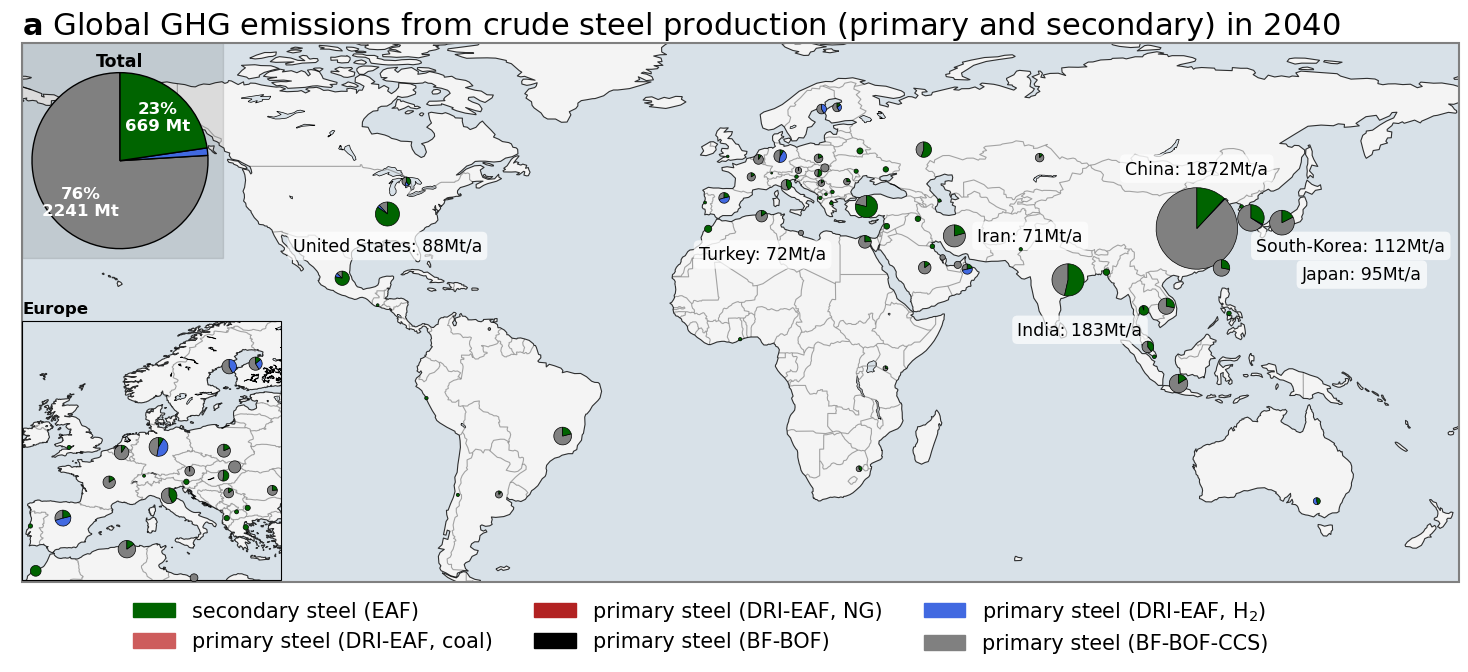

In [77]:
# List of titles and potential columns
titles = [r'$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary) in 2040']

name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"
pot_cols = [name_to_assess]
plot_steel_map(results_df_future_ccs, pot_cols, subplot=False, titles = titles, division_bubble=20, amount_show_bubble=50, export_figure='annual_global_steel_emissions_2040_ccs', 
              dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (0, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-13, -20),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-7, -25),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-5, -5),
                           'Egypt': (-14, 0)
                          }, 
               
               pos_legend_false_subplot = (70, -7))

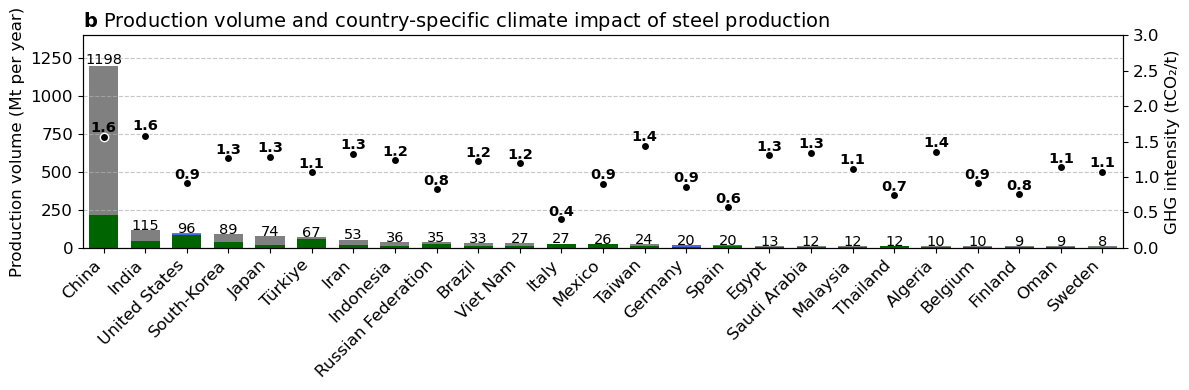

In [78]:
# Example usage
for col in ['production volume']:
    plot_steel_production(results_df_future_ccs, production_col=col, export_figure='prod_fig_intensity_ccs',max_y=1400)

## Calculation CO2 storage requirements

In [79]:
## Calculation of CO2 storage requirements for BF-BOF+CCS steel production
# CO2 stored per kg of steel (kg CO2 per kg steel)
co2_per_kg_steel = 0.7525433761004349  

# Get total production volume (in Mt) of CCS-based steel
steel_production_Mt = (
    results_df_future_ccs.groupby('initial name').sum().loc['BF-BOF+CCS, steel production, low-alloyed']['production volume'] +
    results_df_future_ccs.groupby('initial name').sum().loc['BF-BOF+CCS, steel production, unalloyed']['production volume']
)

# Convert steel production from Mt to kg
steel_production_kg = steel_production_Mt * 1e9  # 1 Mt = 1e9 kg

# Calculate total CO2 storage required in Mt
co2_storage_Mt = co2_per_kg_steel * steel_production_kg / 1e9

# Output result
f"Estimated CO2 storage needed for BF-BOF+CCS steel production is approximately {co2_storage_Mt:.2f} Mt CO2."

'Estimated CO2 storage needed for BF-BOF+CCS steel production is approximately 1059.13 Mt CO2.'